#  Прогнозирование заказов такси

В нашем распоряжении исторические данные о заказах такси в аэропортах с интервалом 10 минут. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных-и-инструментов" data-toc-modified-id="Подготовка-данных-и-инструментов-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных и инструментов</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Feature-engineering-+-Linear-Regression" data-toc-modified-id="Feature-engineering-+-Linear-Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature engineering + Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Base-Linear-Regression" data-toc-modified-id="Base-Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Base Linear Regression</a></span></li><li><span><a href="#Linear-Regression-production-imitation" data-toc-modified-id="Linear-Regression-production-imitation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Regression production imitation</a></span></li><li><span><a href="#Linear-Regression-result" data-toc-modified-id="Linear-Regression-result-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Linear Regression result</a></span></li></ul></li><li><span><a href="#Feature-engineering-+-LightGBM-for-prediction-difference" data-toc-modified-id="Feature-engineering-+-LightGBM-for-prediction-difference-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature engineering + LightGBM for prediction difference</a></span><ul class="toc-item"><li><span><a href="#Base-LightGBM" data-toc-modified-id="Base-LightGBM-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Base LightGBM</a></span></li><li><span><a href="#LightGBM-result" data-toc-modified-id="LightGBM-result-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LightGBM result</a></span></li></ul></li><li><span><a href="#sktime-models" data-toc-modified-id="sktime-models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sktime models</a></span><ul class="toc-item"><li><span><a href="#TBATS-sktime" data-toc-modified-id="TBATS-sktime-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>TBATS sktime</a></span></li><li><span><a href="#KNeighborsRegressor-sktime" data-toc-modified-id="KNeighborsRegressor-sktime-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>KNeighborsRegressor sktime</a></span></li><li><span><a href="#LinearRegression-sktime" data-toc-modified-id="LinearRegression-sktime-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>LinearRegression sktime</a></span></li><li><span><a href="#CatBoostRegressor-sktime" data-toc-modified-id="CatBoostRegressor-sktime-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>CatBoostRegressor sktime</a></span></li><li><span><a href="#AutoETS-sktime" data-toc-modified-id="AutoETS-sktime-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>AutoETS sktime</a></span></li></ul></li><li><span><a href="#Final-test" data-toc-modified-id="Final-test-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Final test</a></span><ul class="toc-item"><li><span><a href="#Baseline-final" data-toc-modified-id="Baseline-final-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Baseline final</a></span></li><li><span><a href="#LinearRegression-final" data-toc-modified-id="LinearRegression-final-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>LinearRegression final</a></span></li></ul></li></ul></div>

In [10]:
# Загружаем данные и ресемплируем по одному часу
try:
    df = pd.read_csv(r"C:\Users\dlbol\Downloads\taxi.csv", parse_dates=True, index_col='datetime')
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col='datetime')
df

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

## Подготовка данных и инструментов

In [1]:
#!pip install lightGBM
#!pip install pmdarima
#!pip install prophet
#!pip install sktime --user
#!pip install tbats

In [2]:
# Подгружаем необходимые библиотеки
from catboost import CatBoostRegressor
from IPython.display import set_matplotlib_formats
import itertools
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from prophet import Prophet
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import norm, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.tbats import TBATS
from sktime.utils.plotting import plot_series
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
import time
from tqdm import tqdm
import warnings
set_matplotlib_formats('retina')
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/tmp/ipykernel_135/1522905310.py:24: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [3]:
# Загружаем данные и ресемплируем по одному часу
try:
    df = pd.read_csv(r"C:\Users\dlbol\Downloads\taxi.csv", parse_dates=True, index_col='datetime')
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col='datetime')
df = df.resample('1H').sum()

In [4]:
df

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [5]:
# Сразу отделим отложенную выборку
df_full = df.copy()
df, test = train_test_split(df, shuffle=False, test_size=0.1)

In [6]:
# Инициализируем plotly
init_notebook_mode(connected = True)

# Определяем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

# Определяем функцию визуализирующую трендовую, сезонную и остаточную компоненты
def decompose_plot(y, figsize=(15, 10), style='seaborn-darkgrid'):
    decomposed = seasonal_decompose(df)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        ax_1 = fig.add_subplot(4, 1, 1)
        ax_2 = fig.add_subplot(4, 1, 2)
        ax_3 = fig.add_subplot(4, 1, 3)
        ax_4 = fig.add_subplot(4, 1, 4)

        decomposed.trend.plot(ax=ax_1)
        decomposed.seasonal.plot(ax=ax_2)
        decomposed.seasonal['2018-05-01':'2018-05-10'].plot(ax=ax_3)
        decomposed.resid.plot(ax=ax_4)
        
        ax_1.set_title('Trend component', fontsize = 20)
        ax_2.set_title('Seasonal component', fontsize = 20)
        ax_3.set_title('Seasonal component (10 days)', fontsize = 20)
        ax_4.set_title('Residual component', fontsize = 20)
        
        plt.tight_layout()
        
# Определяем функцию визуализирующую автокорреляцию и частичную автокорреляцию
def corr_plot(y, lags=None, figsize=(12, 7), style='seaborn-darkgrid'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        acf_ax = fig.add_subplot(2, 1, 1)
        pacf_ax = fig.add_subplot(2, 1, 2)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()

In [7]:
plotly_df(df, title = 'Количество заказов такси')

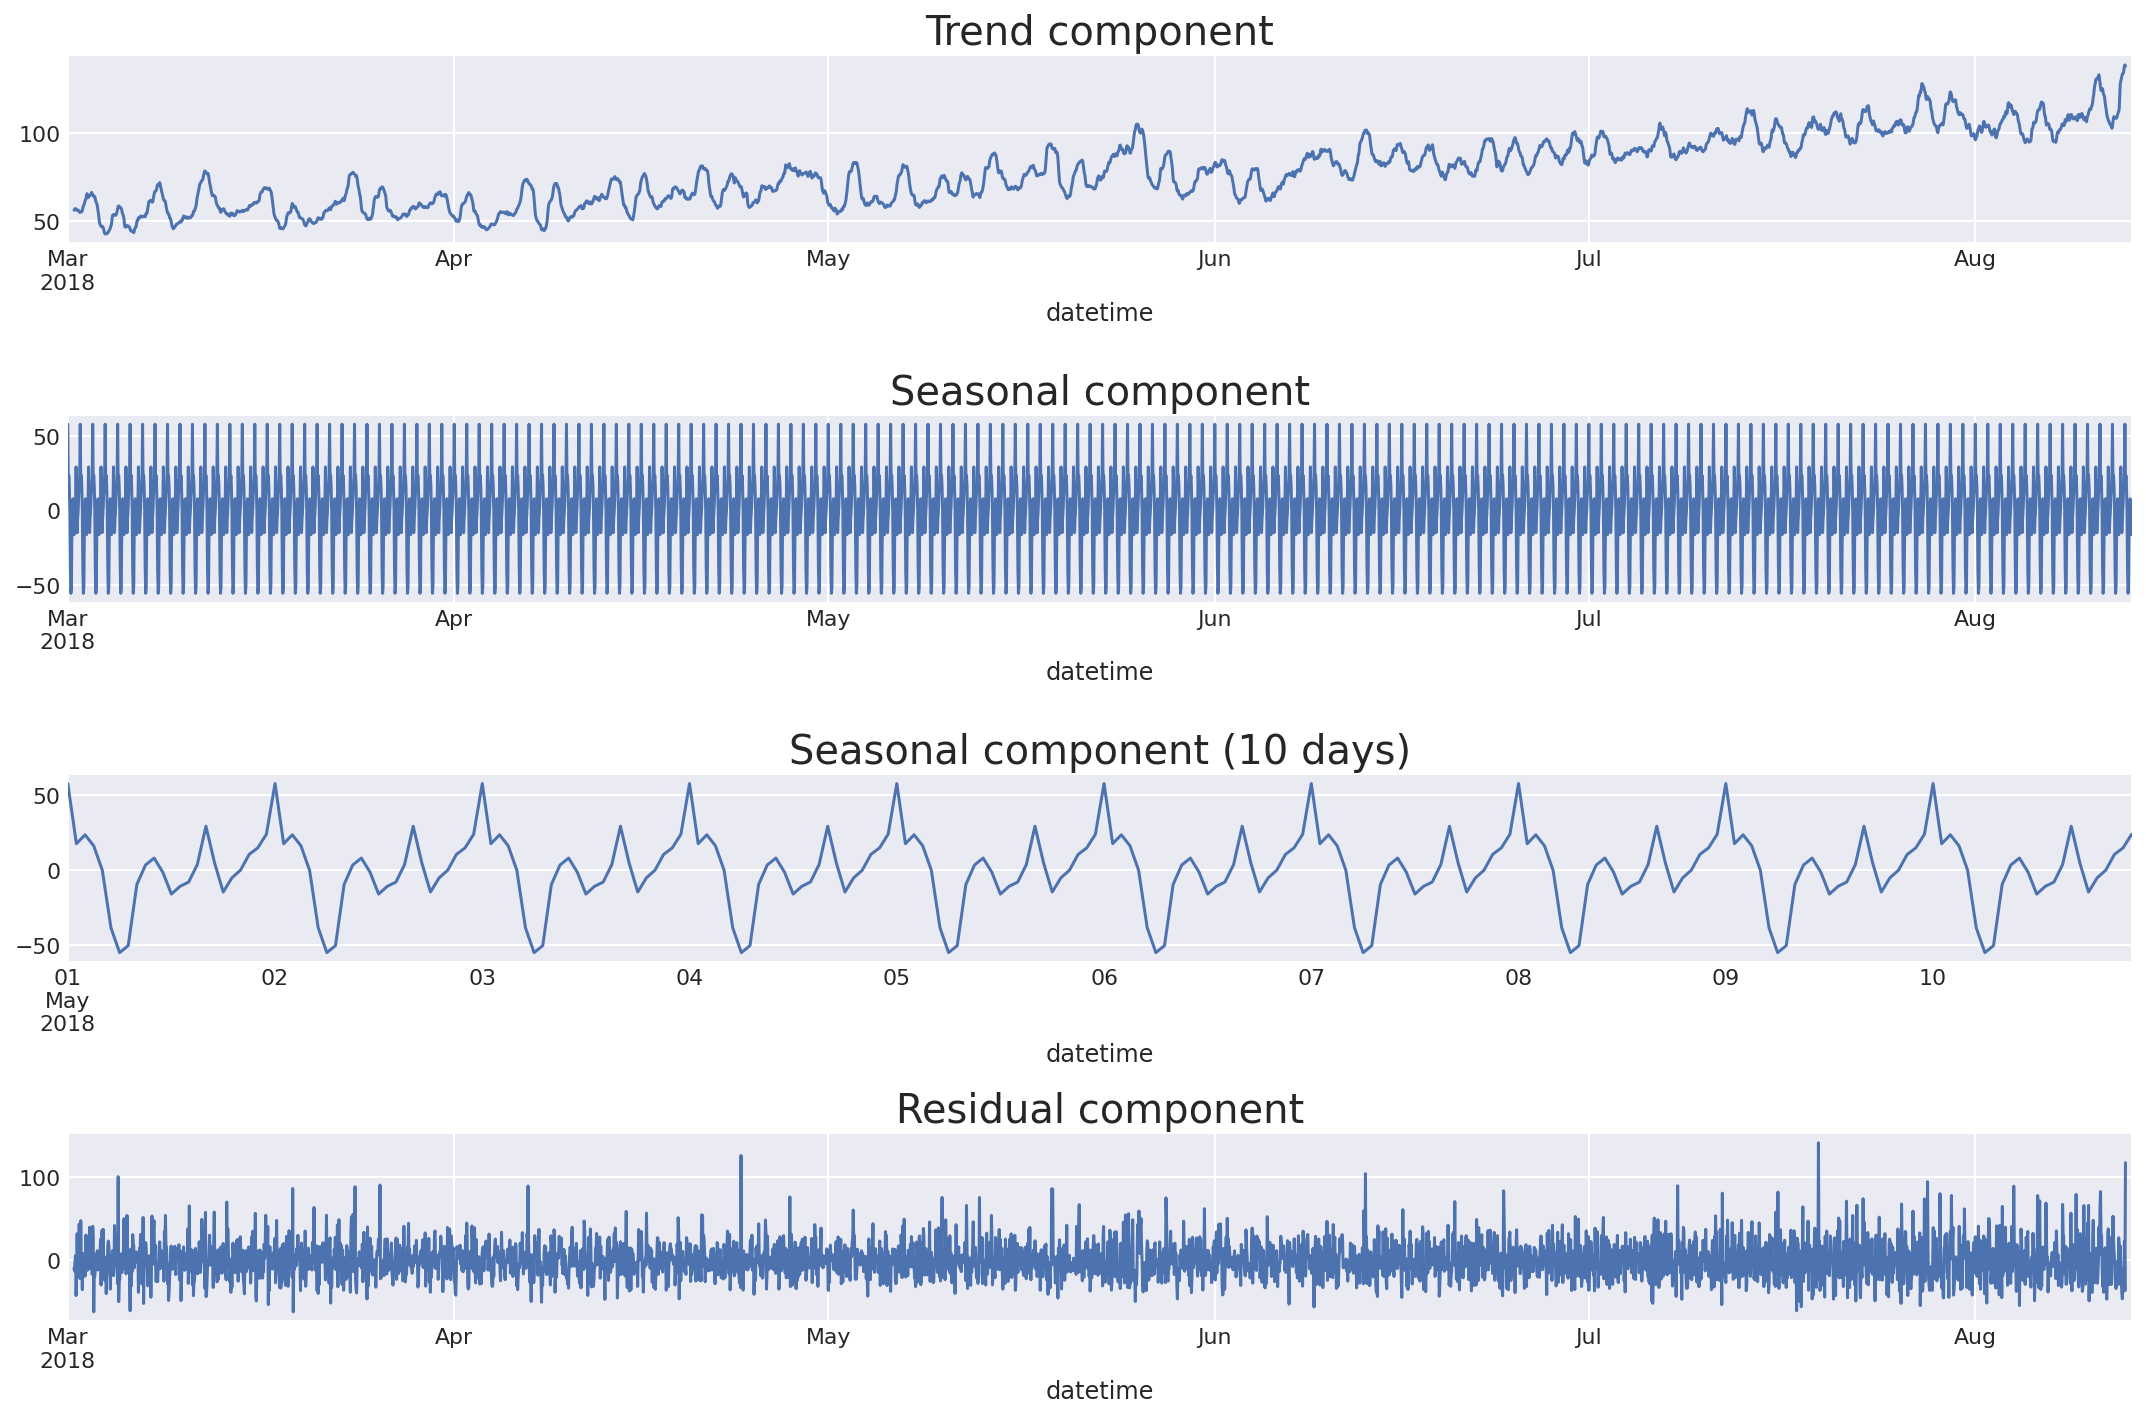

In [8]:
decompose_plot(df.num_orders)

В данном временном ряде имеются отчетливый восходящий тренд и суточная сезонность. Остаточная компонента выглядит достаточно стационарной.

Dickey-Fuller criterion: p=0.000732


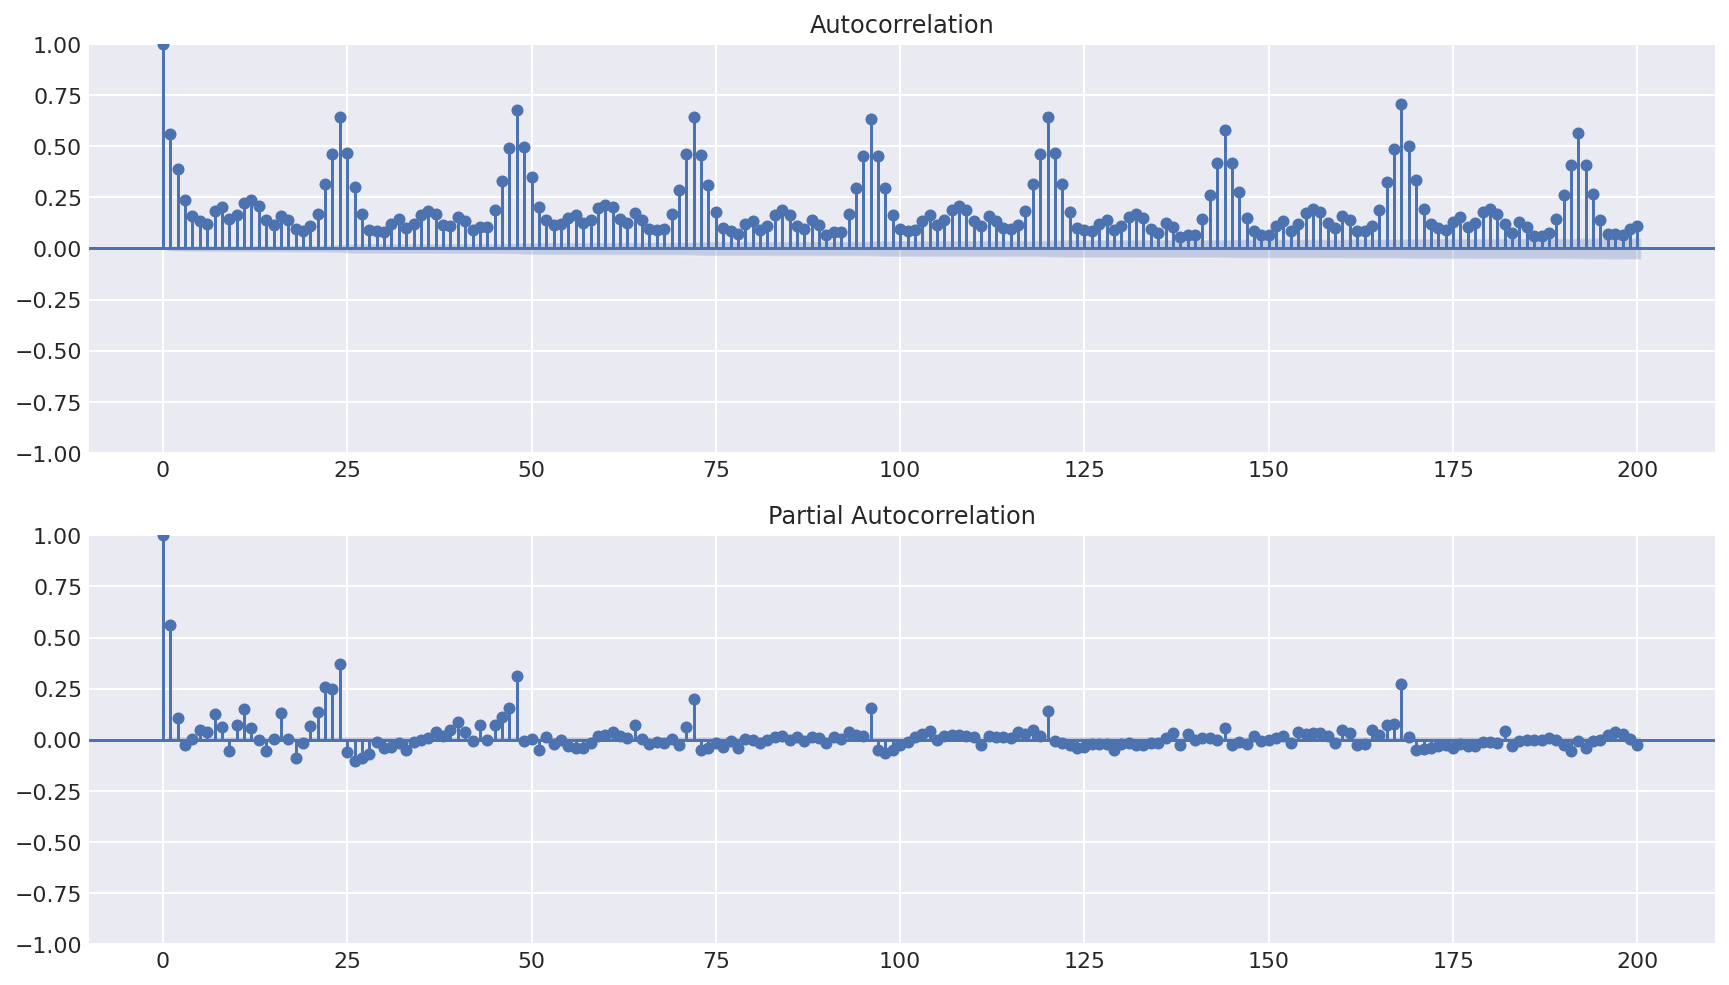

In [9]:
corr_plot(df.num_orders, lags=200)

Критерий Дики-Фуллера говорит о стационарности ряда, несмотря на на наличие трендовой компоненты, что легко понять, посмотрев на график автокорреляции - сезонность практически полностью перекрывает влияние тренда. На графике частичной автокорреляции отчетливо выдеяются лаги 24, 48, 72 и тд, что говорит о суточной сезонности. Также после естесственного спада с увеличением суточных интервалов, 168 лаг вновь показывает весьма высокую взаимосвязь, что говорит о наличии недельной сезонности (168ч - 7сут).

## Baseline 

In [7]:
# Определяем функцию метрики
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [8]:
train, val = train_test_split(df, shuffle=False, test_size=0.1)
const_mean = np.ones(val.shape[0]) * train.mean().values[0]
const_last = np.ones(val.shape[0]) * train.values[-1]
dynamic_last = val.shift().fillna(train.values[-1][0])
print(f'''constant mean score: {rmse(val, const_mean)}
constant last score: {rmse(val, const_last)}
dynamic last score: {rmse(val, dynamic_last)}''')

constant mean score: 58.46718636591692
constant last score: 47.82479540234733
dynamic last score: 47.268372036435466


## Prophet

Для первого прогноза воспользуемся библитекой Prophet, так как она позволяет быстро и без настройки сделать базовый прогноз и оценить сезонности.

In [9]:
predictions = df.shape[0] // 10

# приводим dataframe к нужному формату
data = df.copy()
data = data.reset_index()
data.columns = ['ds', 'y']

# отрезаем из обучающей выборки последние 10% точек, чтобы измерить на них качество
train_df = data[:-predictions] 

m = Prophet()
m.add_country_holidays(country_name='RU')
m.fit(train_df)
future = m.make_future_dataframe(periods=predictions, freq='H')
forecast = m.predict(future)
pred = forecast['yhat'][-predictions:].values
y_true = data['y'][-predictions:].values
print(f'RMSE: {rmse(y_true, pred):.2f}')

02:38:21 - cmdstanpy - INFO - Chain [1] start processing
02:38:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 34.04


Попробуем улучшить качество преобразованием бокса-кокса.

In [10]:
# Определяем функцию обратного преобразования бокса-кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

predictions = df.shape[0] // 10

# Приводим dataframe к нужному форматуб отрезаем 10% и используем преобразование бокса-кокса
data = df.copy()
data = data.reset_index()
data.columns = ['ds', 'y']
train_df = data[:-predictions]
train_df = train_df.set_index('ds')
train_df['y'] = train_df['y'].replace(0, 1)
train_df['y'], lmbda_prophet = stats.boxcox(train_df['y'])
train_df = train_df.reset_index()

m = Prophet()
m.add_country_holidays(country_name='RU')
m.fit(train_df)
future = m.make_future_dataframe(periods=predictions, freq='H')
forecast = m.predict(future)

forecast['yhat'] = invboxcox(forecast.yhat, lmbda_prophet)
forecast['yhat_lower'] = invboxcox(forecast.yhat_lower, lmbda_prophet)
forecast['yhat_upper'] = invboxcox(forecast.yhat_upper, lmbda_prophet)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data.set_index('ds'))

pred = forecast['yhat'][-predictions:].values
y_true = data['y'][-predictions:].values
print(f'RMSE: {rmse(y_true, pred):.2f}')

02:38:22 - cmdstanpy - INFO - Chain [1] start processing
02:38:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 33.42


Теперь осмотрим разложение на компоненты.

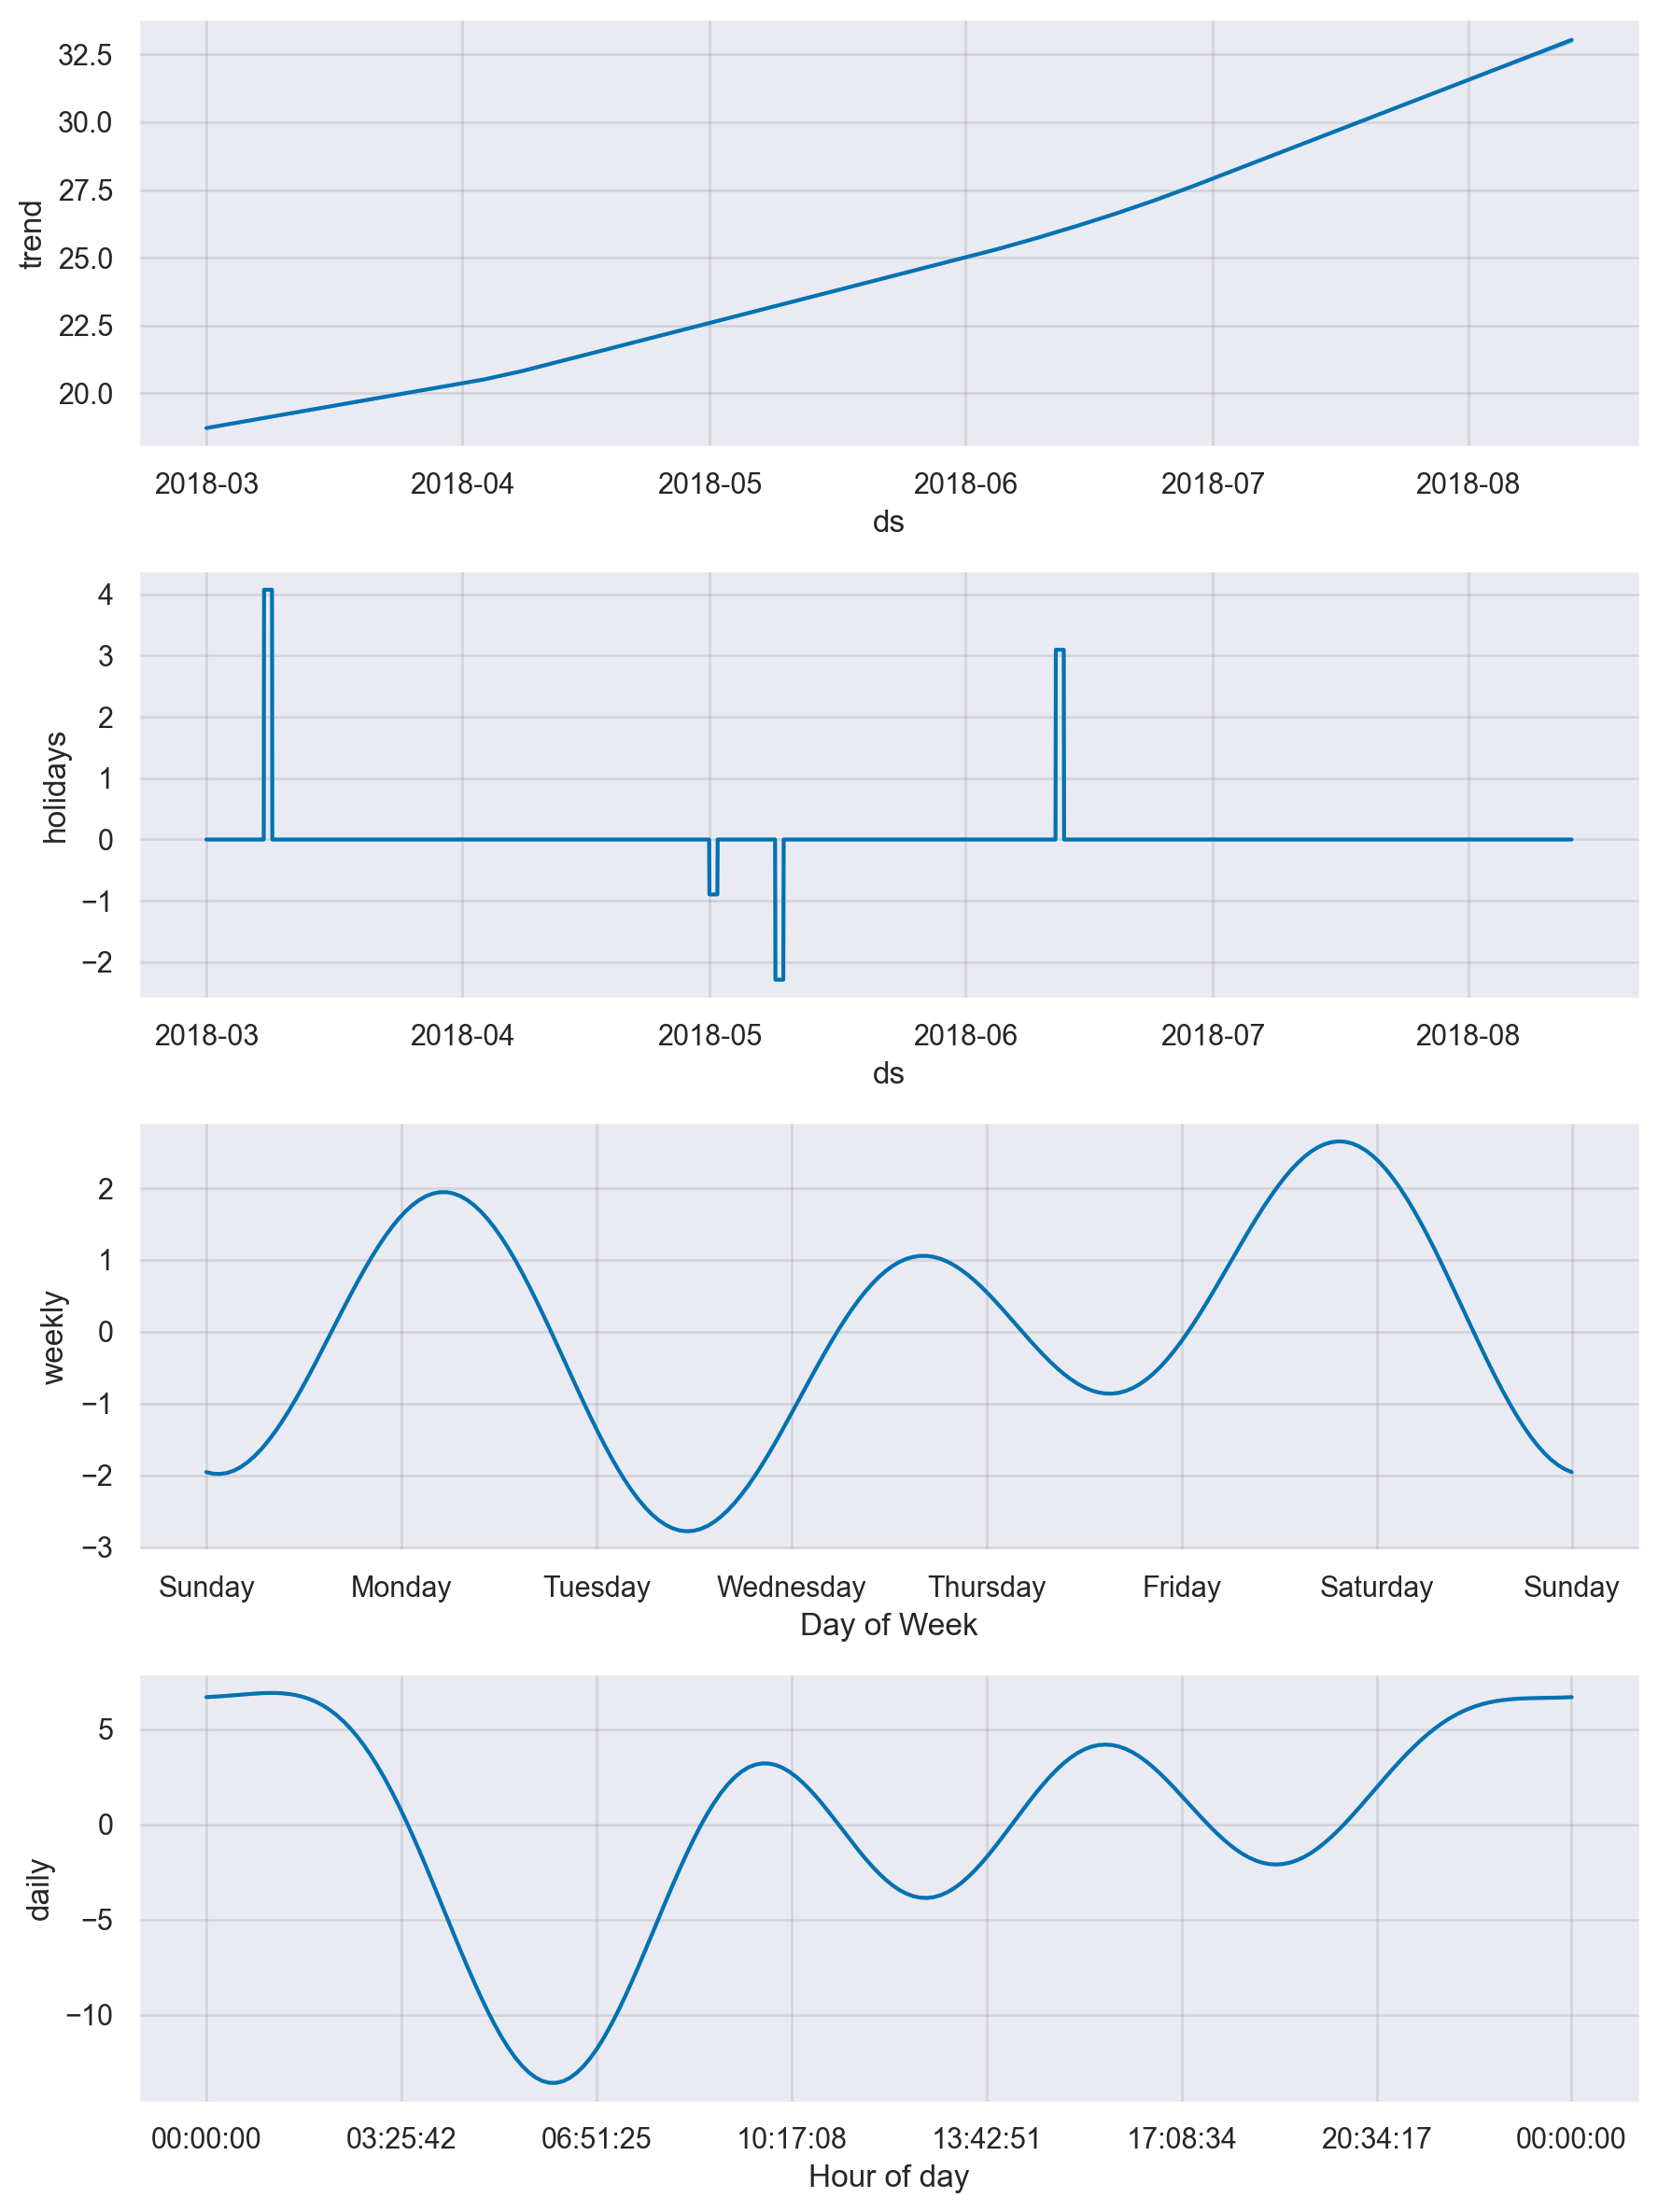

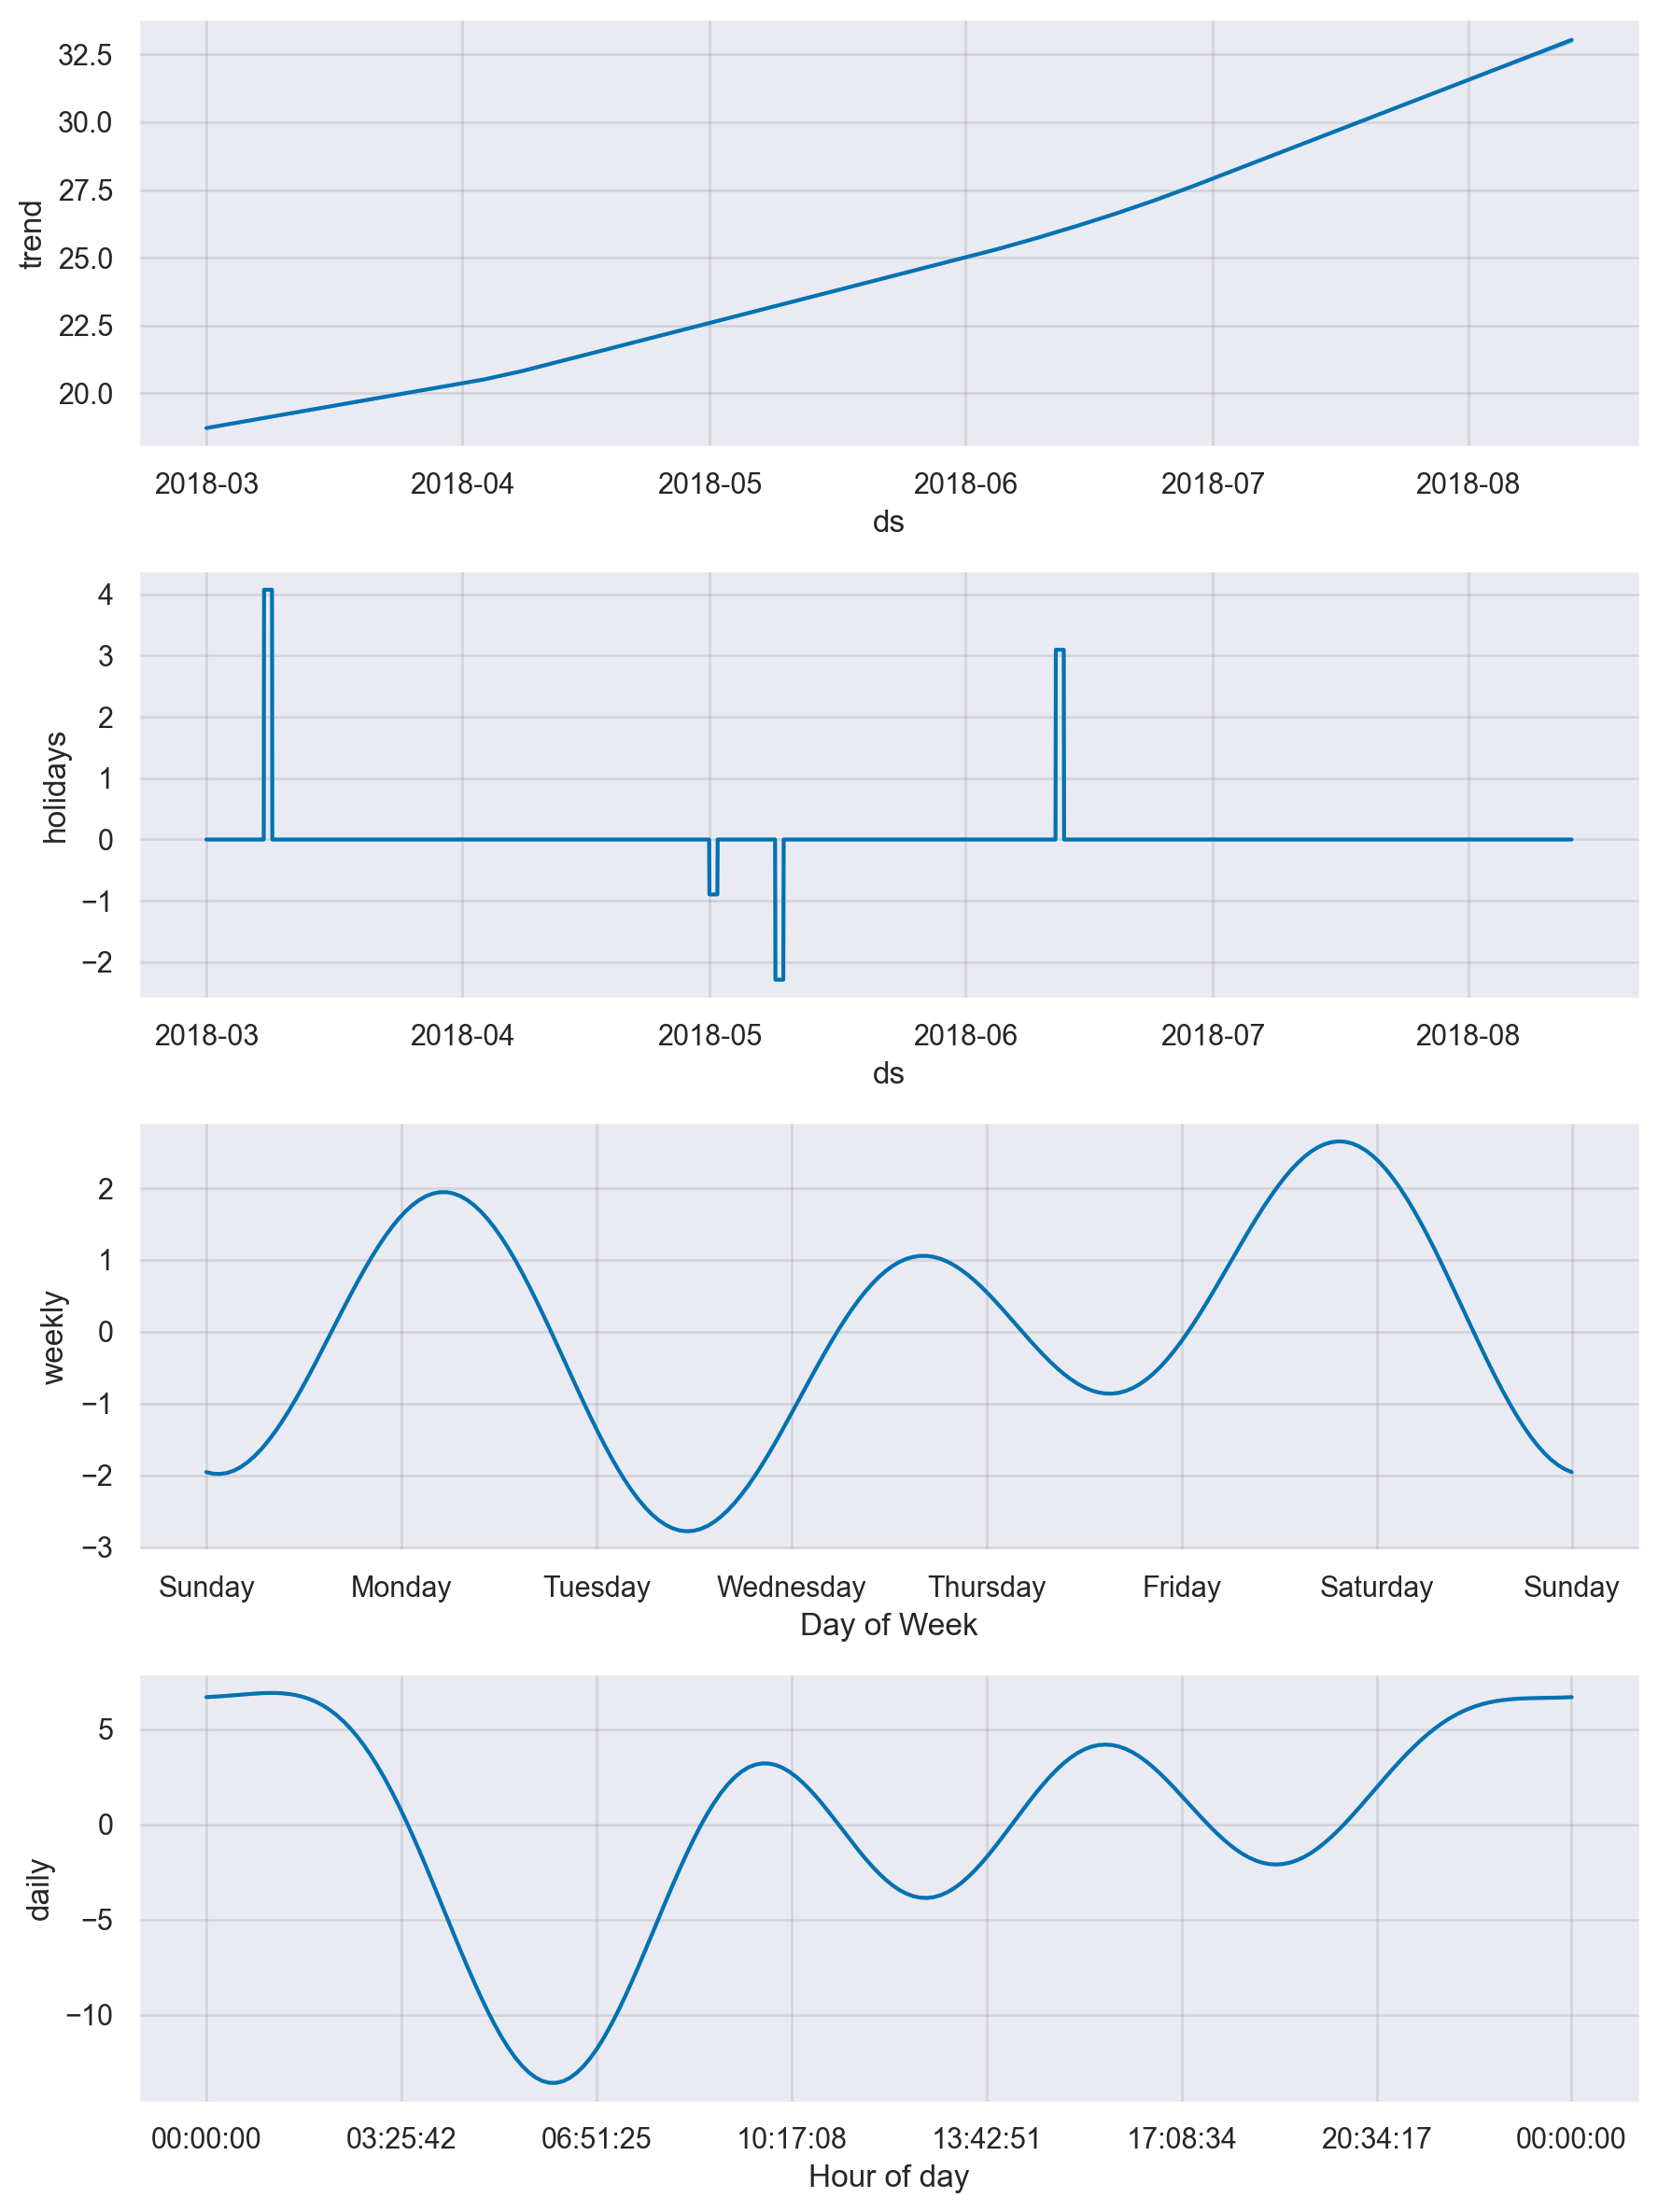

In [11]:
m.plot_components(forecast)

Модель нашла суточные и недельные сезонности, а также общий восходящий тренд.

In [12]:
# функция для визуализации построенного прогноза
def show_forecast(cmp_df, num_predictions, num_values):
    # верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="green"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    # прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="green"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Заказы'),
        title='Количество заказов такси',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, 397, 600)

## Feature engineering + Linear Regression

Второй обучим линейную регрессию, предварительно создав следующие признаки: месяц, число, день недели, час, некоторое количество прошлых значений, среднее прошлых значений посчитанных скользящим и расширяющимся окном, количество пиков и эксцесс Фишера и разница между прошлыми значениями. 

### Base Linear Regression

In [16]:
def make_features(data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['expanding_mean'] = data['num_orders'].shift().expanding(expanding_size).mean()
    data['peaks'] = data['num_orders'].shift().rolling(rolling_peaks_size).apply(lambda x: len(find_peaks(x)[0]))
    data['kurtosis'] = data['num_orders'].shift().rolling(rolling_kurtosis_size).apply(lambda x: kurtosis(x))
    data['kurtosis'] = data['kurtosis'].fillna(0)
    
    for diff in range(1, max_diff + 1):
        data['diff_{}'.format(diff)] = data['num_orders'].shift().diff(periods = diff)
    
def base_linreg(data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff):
    temp_data = data.copy()
    make_features(temp_data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff)
    train, val = train_test_split(temp_data, shuffle=False, test_size=0.1)
    train = train.dropna()
    y_train = train['num_orders']
    train = train.drop(columns='num_orders')
    y_val = val['num_orders']
    val = val.drop(columns='num_orders')
    model = LinearRegression()
    model.fit(train, y_train)
    pred = model.predict(val)
    return rmse(y_val, pred)

In [14]:
ls = [2, 50, 100, 200]
params_list = list(itertools.product(ls, ls, ls, ls, ls, ls))
best = np.inf
for max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff in tqdm(params_list):
    score = base_linreg(df, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff)
    if score < best:
        best = score
        best_params = max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff
print(f'''score: {best:.2f}
max_lag: {best_params[0]}
rolling_mean_size: {best_params[1]}
expanding_size: {best_params[2]}
rolling_peaks_size: {best_params[3]}
rolling_kurtosis_size: {best_params[4]}
max_diffe: {best_params[5]}''')

100%|████████████████████████████████████████████████████████████████████████████| 4096/4096 [1:37:58<00:00,  1.44s/it]

score: 28.30
max_lag: 200
rolling_mean_size: 2
expanding_size: 2
rolling_peaks_size: 50
rolling_kurtosis_size: 2
max_diffe: 100


In [53]:
params_list = list(itertools.product([190, 200, 210],
                                    [2, 5, 7],
                                    [2, 5, 7],
                                    [40, 50, 60],
                                    [2, 5, 7],
                                    [90, 100, 110]))
best = np.inf
for max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff in tqdm(params_list):
    score = base_linreg(df, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff)
    if score < best:
        best = score
        best_params = max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff
print(f'''score: {best:.2f}
max_lag: {best_params[0]}
rolling_mean_size: {best_params[1]} 
expanding_size: {best_params[2]}
rolling_peaks_size: {best_params[3]}
rolling_kurtosis_size: {best_params[4]}
max_diff: {best_params[5]}''')

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [24:29<00:00,  2.02s/it]

score: 28.23
max_lag: 200
rolling_mean_size: 5 
expanding_size: 2
rolling_peaks_size: 60
rolling_kurtosis_size: 7
max_diff: 100


Попробуем также использовать стандартное масштабирование для линейных моделей.

In [54]:
def base_linreg_scale(data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff):
    temp_data = data.copy()
    make_features(temp_data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff)
    train, val = train_test_split(temp_data, shuffle=False, test_size=0.1)
    train = train.dropna()
    y_train = train['num_orders']
    train = train.drop(columns='num_orders')
    y_val = val['num_orders']
    val = val.drop(columns='num_orders')
    model = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
    model.fit(train, y_train)
    pred = model.predict(val)
    return rmse(y_val, pred)

In [55]:
print(f'RMSE: {base_linreg_scale(df, *best_params):.2f}')

RMSE: 28.84


### Linear Regression production imitation

Сымитируем работу модели в продакте и оценим если смысл в построении online модели, которая будет каждый час переобучаться.

In [56]:
def linreg(data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff):
    temp_data = data.copy()
    make_features(temp_data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size, max_diff)
    temp_data = temp_data.dropna()
    num_all = temp_data.shape[0]
    num_train = num_all - num_all // 10
    y_true = []
    y_pred = []
    for i in range(num_train, num_all):
        temp = temp_data.iloc[:i]
        train = temp.drop(columns='num_orders').values
        y_train = temp['num_orders'].values
        model = LinearRegression()
        model.fit(train, y_train)
        temp = temp_data.iloc[i]
        val = temp.drop('num_orders').values.reshape(1, -1)
        y_true.append(temp['num_orders'])
        y_pred.append(model.predict(val))
    return rmse(y_true, y_pred)

In [57]:
print(f'RMSE: {linreg(df, *best_params):.2f}')

RMSE: 28.46


В итоге качество не улучшилось (даже немного ухудшилось, возможно случайно), соответственно данную модель можно нечасто обновлять (offline модели будет достаточно).

### Linear Regression result

RMSE: 28.23300028267132


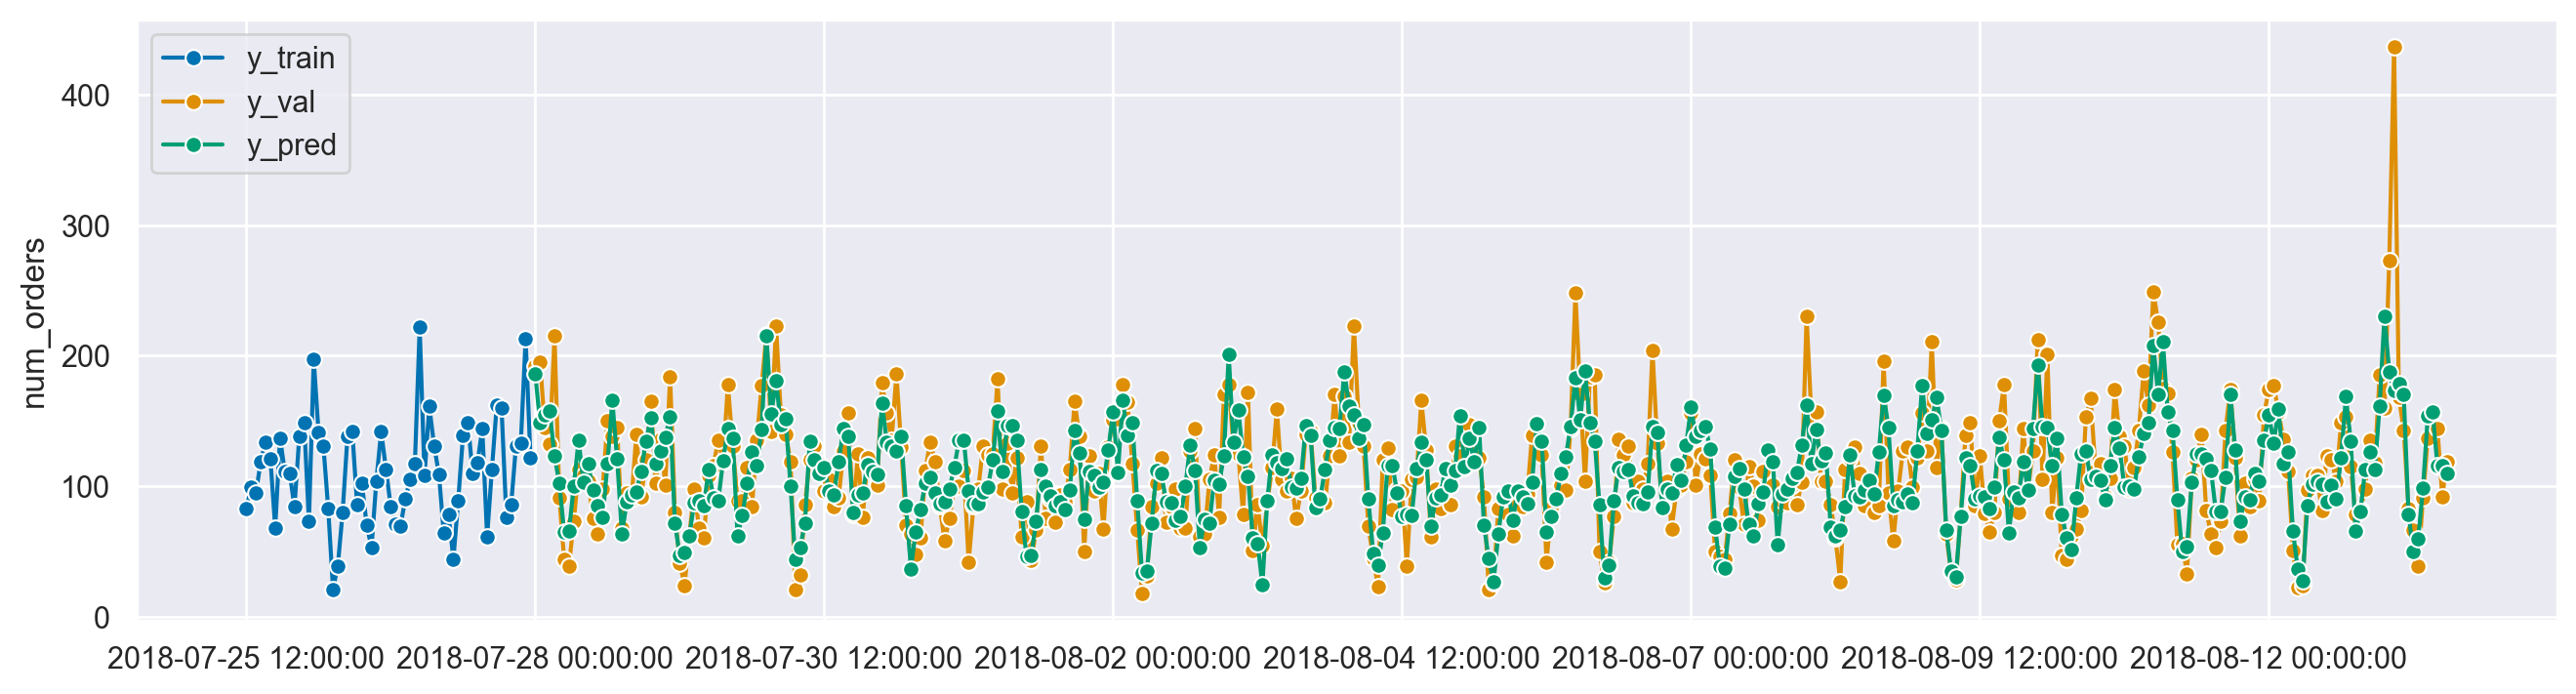

In [22]:
temp_data = df.copy()
make_features(temp_data, *best_params)
train, val = train_test_split(temp_data, shuffle=False, test_size=0.1)
train = train.dropna()
y_train = train['num_orders']
train = train.drop(columns='num_orders')
y_val = val['num_orders']
val = val.drop(columns='num_orders')
model = LinearRegression()
model.fit(train, y_train)
pred = model.predict(val)
y_pred = pd.Series(pred, index=y_val.index)
plot_series(y_train.tail(60), y_val, y_pred, labels=["y_train", "y_val", "y_pred"])
print(f'RMSE: {rmse(y_val, y_pred):.2f}')

## Feature engineering + LightGBM for prediction difference

Следующей обучим модель градиентного бустинга, также предварительно создав признаки как для линейной регрессии за исключением разницы предыдущих значений. Так как мы будем предсказывать разницу между прогнозируемым и прошлым значением, чтобы обойти пролему деревянных моделей - невозможность экстраполяции (что может быть важно, учитывая тренд временного ряда).

### Base LightGBM

In [64]:
def make_features(data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['expanding_mean'] = data['num_orders'].shift().expanding(expanding_size).mean()
    data['peaks'] = data['num_orders'].shift().rolling(rolling_peaks_size).apply(lambda x: len(find_peaks(x)[0]))
    data['kurtosis'] = data['num_orders'].shift().rolling(rolling_kurtosis_size).apply(lambda x: kurtosis(x))
    data['kurtosis'] = data['kurtosis'].fillna(0)
    data['diff'] = data['num_orders'].diff()

def base_lgb(data,
             boosting_type='gbdt', 
             num_leaves=31, 
             max_depth=-1, 
             learning_rate=0.1, 
             n_estimators=100, 
             min_child_samples=20,
             max_lag=2,
             rolling_mean_size=2,
             expanding_size=2, 
             rolling_peaks_size=2, 
             rolling_kurtosis_size=2):

    temp_data = data.copy()
    make_features(temp_data, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size)
    train, val = train_test_split(temp_data, shuffle=False, test_size=0.1)
    train = train.dropna()
    y_train = train['diff']
    lost_value = train['num_orders'].values[-1]
    train = train.drop(columns=['num_orders', 'diff'])
    y_val = val['num_orders']
    val = val.drop(columns=['num_orders', 'diff'])
    
    booster = lgb.LGBMRegressor(boosting_type=boosting_type, 
                                num_leaves=num_leaves, 
                                max_depth=max_depth, 
                                learning_rate=learning_rate, 
                                n_estimators=n_estimators, 
                                min_child_samples=min_child_samples, 
                                random_state=42)
    start_time = time.time()
    booster.fit(train, y_train)
    pred = booster.predict(val)
    fit_pred_time = time.time() - start_time
    
    pred = y_val.shift().fillna(lost_value) + pred
    score = rmse(y_val, pred)
    
    return score, fit_pred_time, booster

In [24]:
ls = [2, 50, 100, 200]
logs = []
params_list = list(itertools.product(ls, ls, ls, ls, ls))
best = np.inf
for max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             max_lag=max_lag,
                                             rolling_mean_size=rolling_mean_size,
                                             expanding_size=expanding_size, 
                                             rolling_peaks_size=rolling_peaks_size, 
                                             rolling_kurtosis_size=rolling_kurtosis_size)
    logs.append((score, fit_pred_time, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size))

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [32:51<00:00,  1.93s/it]


In [25]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'max_lag', 'rolling_mean_size', 
                                      'expanding_size', 'rolling_peaks_size', 'rolling_kurtosis_size'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time  max_lag  rolling_mean_size  expanding_size  \
833  30.118537       0.626479      200                 50               2   
849  30.118537       0.614076      200                 50              50   
865  30.118537       0.460169      200                 50             100   
881  30.118537       0.466688      200                 50             200   
929  30.161188       0.621891      200                100             100   
945  30.161188       0.640432      200                100             200   
897  30.161188       0.630424      200                100               2   
913  30.161188       0.631417      200                100              50   
841  30.243088       0.630941      200                 50               2   
857  30.243088       0.621974      200                 50              50   

     rolling_peaks_size  rolling_kurtosis_size  
833                   2                     50  
849                   2                     50  
865                   2                     50  
881                   2                     50  
929                   2                     50  
945                   2                     50  
897                   2                     50  
913                   2                     50  
841                 100                     50  
857                 100                     50

In [26]:
logs = []
params_list = list(itertools.product([150, 200, 250],
                                     [25, 50, 75],
                                     [2, 7, 20],
                                     [2, 7, 20],
                                     [25, 50, 75]))
best = np.inf
for max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             max_lag=max_lag,
                                             rolling_mean_size=rolling_mean_size,
                                             expanding_size=expanding_size, 
                                             rolling_peaks_size=rolling_peaks_size, 
                                             rolling_kurtosis_size=rolling_kurtosis_size)
    logs.append((score, fit_pred_time, max_lag, rolling_mean_size, expanding_size, rolling_peaks_size, rolling_kurtosis_size))

100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [09:17<00:00,  2.29s/it]


In [27]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'max_lag', 'rolling_mean_size', 
                                      'expanding_size', 'rolling_peaks_size', 'rolling_kurtosis_size'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time  max_lag  rolling_mean_size  expanding_size  \
241  29.949273       0.776313      250                 75              20   
223  29.949273       0.736474      250                 75               2   
232  29.949273       0.792604      250                 75               7   
204  30.050730       0.761669      250                 50               7   
213  30.050730       0.765665      250                 50              20   
195  30.050730       0.794450      250                 50               2   
130  30.109352       0.641829      200                 50              20   
121  30.109352       0.628092      200                 50               7   
112  30.109352       0.631713      200                 50               2   
109  30.118537       0.633103      200                 50               2   

     rolling_peaks_size  rolling_kurtosis_size  
241                  20                     50  
223                  20                     50  
232                  20                     50  
204                  20                     25  
213                  20                     25  
195                  20                     25  
130                   7                     50  
121                   7                     50  
112                   7                     50  
109                   2                     50

In [28]:
logs = []
params_list = list(itertools.product([225, 250, 300],
                                     [10, 20, 25],
                                     [10, 20, 25]))
best = np.inf
for max_lag, expanding_size, rolling_peaks_size in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             max_lag=max_lag,
                                             rolling_mean_size=75,
                                             expanding_size=expanding_size, 
                                             rolling_peaks_size=rolling_peaks_size, 
                                             rolling_kurtosis_size=50)
    logs.append((score, fit_pred_time, max_lag, 75, expanding_size, rolling_peaks_size, 50))

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:04<00:00,  2.38s/it]


In [29]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'max_lag', 'rolling_mean_size', 
                                      'expanding_size', 'rolling_peaks_size', 'rolling_kurtosis_size'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time  max_lag  rolling_mean_size  expanding_size  \
13  29.949273       0.793410      250                 75              20   
16  29.949273       0.755597      250                 75              25   
10  29.949273       0.765101      250                 75              10   
17  30.423234       0.818230      250                 75              25   
14  30.423234       0.762965      250                 75              20   
11  30.423234       0.765040      250                 75              10   
23  30.490010       0.582333      300                 75              20   
20  30.490010       0.681099      300                 75              10   
26  30.490010       0.593755      300                 75              25   
24  30.490150       0.600414      300                 75              25   

    rolling_peaks_size  rolling_kurtosis_size  
13                  20                     50  
16                  20                     50  
10                  20                     50  
17                  25                     50  
14                  25                     50  
11                  25                     50  
23                  25                     50  
20                  25                     50  
26                  25                     50  
24                  10                     50

In [30]:
logs = []
params_list = list(itertools.product(['gbdt', 'dart', 'goss'],
                                     [31, 100, 500],
                                     [5, 20, 100],
                                     [0.001, 0.01, 0.1],
                                     [50, 100, 200],
                                     [10, 20, 50]))
best = np.inf
for boosting_type, num_leaves, max_depth, learning_rate, n_estimators, min_child_samples in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             boosting_type=boosting_type, 
                                             num_leaves=num_leaves, 
                                             max_depth=max_depth, 
                                             learning_rate=learning_rate, 
                                             n_estimators=n_estimators, 
                                             min_child_samples=min_child_samples,
                                             max_lag=250,
                                             rolling_mean_size=75,
                                             expanding_size=20, 
                                             rolling_peaks_size=20, 
                                             rolling_kurtosis_size=50)
    logs.append((score, fit_pred_time, boosting_type, num_leaves, max_depth, learning_rate, n_estimators, min_child_samples))

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [41:13<00:00,  3.39s/it]


In [31]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'boosting_type', 'num_leaves', 
                                      'max_depth', 'learning_rate', 'n_estimators', 'min_child_samples'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time boosting_type  num_leaves  max_depth  \
242  29.766147       1.997353          gbdt         500        100   
161  29.766147       1.343484          gbdt         100        100   
106  29.858633       0.485924          gbdt         100          5   
25   29.858633       0.738168          gbdt          31          5   
187  29.858633       0.648212          gbdt         500          5   
78   29.945119       1.910065          gbdt          31        100   
51   29.945119       1.627011          gbdt          31         20   
134  29.947967       1.704366          gbdt         100         20   
215  29.947967       1.845690          gbdt         500         20   
76   29.949273       0.758059          gbdt          31        100   

     learning_rate  n_estimators  min_child_samples  
242            0.1           200                 50  
161            0.1           200                 50  
106            0.1           200                 20  
25             0.1           200                 20  
187            0.1           200                 20  
78             0.1           200                 10  
51             0.1           200                 10  
134            0.1           200                 50  
215            0.1           200                 50  
76             0.1           100                 20

In [32]:
logs = []
params_list = list(itertools.product([500, 1000, 2000],
                                     [100, 200, 300],
                                     [200, 300, 400],
                                     [50, 100, 200]))
best = np.inf
for num_leaves, max_depth, n_estimators, min_child_samples in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             boosting_type='gbdt', 
                                             num_leaves=num_leaves, 
                                             max_depth=max_depth, 
                                             learning_rate=0.1, 
                                             n_estimators=n_estimators, 
                                             min_child_samples=min_child_samples,
                                             max_lag=250,
                                             rolling_mean_size=75,
                                             expanding_size=20, 
                                             rolling_peaks_size=20, 
                                             rolling_kurtosis_size=50)
    logs.append((score, fit_pred_time, 'gbdt', num_leaves, max_depth, 0.1, n_estimators, min_child_samples))

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [07:03<00:00,  5.23s/it]


In [33]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'boosting_type', 'num_leaves', 
                                      'max_depth', 'learning_rate', 'n_estimators', 'min_child_samples'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time boosting_type  num_leaves  max_depth  \
60  29.739325       7.073189          gbdt        2000        100   
78  29.739325       7.005534          gbdt        2000        300   
42  29.739325       6.107195          gbdt        1000        200   
33  29.739325       5.889321          gbdt        1000        100   
6   29.739325       5.881735          gbdt         500        100   
51  29.739325       5.816444          gbdt        1000        300   
24  29.739325       5.877196          gbdt         500        300   
69  29.739325       7.027020          gbdt        2000        200   
15  29.739325       5.748240          gbdt         500        200   
48  29.741200       4.462279          gbdt        1000        300   

    learning_rate  n_estimators  min_child_samples  
60            0.1           400                 50  
78            0.1           400                 50  
42            0.1           400                 50  
33            0.1           400                 50  
6             0.1           400                 50  
51            0.1           400                 50  
24            0.1           400                 50  
69            0.1           400                 50  
15            0.1           400                 50  
48            0.1           300                 50

In [34]:
logs = []
params_list = list(itertools.product([400, 500, 750, 1000],
                                     [30, 40, 50, 60, 70]))
best = np.inf
for n_estimators, min_child_samples in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             boosting_type='gbdt', 
                                             num_leaves=500, 
                                             max_depth=100, 
                                             learning_rate=0.1, 
                                             n_estimators=n_estimators, 
                                             min_child_samples=min_child_samples,
                                             max_lag=250,
                                             rolling_mean_size=75,
                                             expanding_size=20, 
                                             rolling_peaks_size=20, 
                                             rolling_kurtosis_size=50)
    logs.append((score, fit_pred_time, 'gbdt', 500, 100, 0.1, n_estimators, min_child_samples))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:25<00:00, 13.25s/it]


In [35]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'boosting_type', 'num_leaves', 
                                      'max_depth', 'learning_rate', 'n_estimators', 'min_child_samples'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time boosting_type  num_leaves  max_depth  \
12  29.730654      12.062048          gbdt         500        100   
7   29.734809       6.539128          gbdt         500        100   
17  29.736583      16.141642          gbdt         500        100   
2   29.739325       5.533701          gbdt         500        100   
3   30.118056       4.632900          gbdt         500        100   
8   30.127536       6.215225          gbdt         500        100   
13  30.144595       9.849596          gbdt         500        100   
18  30.157129      13.672198          gbdt         500        100   
16  30.299492      19.411482          gbdt         500        100   
11  30.306775      15.037951          gbdt         500        100   

    learning_rate  n_estimators  min_child_samples  
12            0.1           750                 50  
7             0.1           500                 50  
17            0.1          1000                 50  
2             0.1           400                 50  
3             0.1           400                 60  
8             0.1           500                 60  
13            0.1           750                 60  
18            0.1          1000                 60  
16            0.1          1000                 40  
11            0.1           750                 40

In [36]:
logs = []
params_list = list(itertools.product([225, 250, 300],
                                     [10, 20, 25],
                                     [10, 20, 25]))
best = np.inf
for max_lag, expanding_size, rolling_peaks_size in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             boosting_type='gbdt', 
                                             num_leaves=500, 
                                             max_depth=100, 
                                             learning_rate=0.1, 
                                             n_estimators=750, 
                                             min_child_samples=50,
                                             max_lag=max_lag,
                                             rolling_mean_size=75,
                                             expanding_size=expanding_size, 
                                             rolling_peaks_size=rolling_peaks_size, 
                                             rolling_kurtosis_size=50)
    logs.append((score, fit_pred_time, max_lag, 75, expanding_size, rolling_peaks_size, 50))

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [06:30<00:00, 14.45s/it]


In [37]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'max_lag', 'rolling_mean_size', 
                                      'expanding_size', 'rolling_peaks_size', 'rolling_kurtosis_size'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time  max_lag  rolling_mean_size  expanding_size  \
1   29.725954      11.162599      225                 75              10   
4   29.725954      11.357217      225                 75              20   
7   29.725954      11.105677      225                 75              25   
13  29.730654      11.435960      250                 75              20   
16  29.730654      11.603238      250                 75              25   
10  29.730654      11.915041      250                 75              10   
0   29.901940      11.088738      225                 75              10   
6   29.901940      11.305586      225                 75              25   
3   29.901940      11.116185      225                 75              20   
5   29.914513      11.250444      225                 75              20   

    rolling_peaks_size  rolling_kurtosis_size  
1                   20                     50  
4                   20                     50  
7                   20                     50  
13                  20                     50  
16                  20                     50  
10                  20                     50  
0                   10                     50  
6                   10                     50  
3                   10                     50  
5                   25                     50

In [38]:
logs = []
params_list = list(itertools.product([100, 150, 200, 225],
                                     [50, 75, 100],
                                     [30, 50, 70]))
best = np.inf
for max_lag, rolling_mean_size, rolling_kurtosis_size in tqdm(params_list):
    score, fit_pred_time, booster = base_lgb(df,
                                             boosting_type='gbdt', 
                                             num_leaves=500, 
                                             max_depth=100, 
                                             learning_rate=0.1, 
                                             n_estimators=750, 
                                             min_child_samples=50,
                                             max_lag=max_lag,
                                             rolling_mean_size=rolling_mean_size,
                                             expanding_size=20, 
                                             rolling_peaks_size=20, 
                                             rolling_kurtosis_size=rolling_kurtosis_size)
    logs.append((score, fit_pred_time, max_lag, rolling_mean_size, 20, 20, rolling_kurtosis_size))

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [06:36<00:00, 11.01s/it]


In [39]:
df_logs = pd.DataFrame(logs, columns=['score', 'fit_pred_time', 'max_lag', 'rolling_mean_size', 
                                      'expanding_size', 'rolling_peaks_size', 'rolling_kurtosis_size'])
df_logs.sort_values(by='score').head(10)

score  fit_pred_time  max_lag  rolling_mean_size  expanding_size  \
32  29.527598      10.697598      225                 75              20   
35  29.568335      10.394360      225                100              20   
31  29.725954      10.759496      225                 75              20   
34  29.885426      10.483525      225                100              20   
28  29.889034      10.041009      225                 50              20   
27  29.926259       9.923931      225                 50              20   
33  29.989781      10.630332      225                100              20   
29  30.022265      10.450755      225                 50              20   
30  30.091503      10.600083      225                 75              20   
23  30.267369       9.707930      200                 75              20   

    rolling_peaks_size  rolling_kurtosis_size  
32                  20                     70  
35                  20                     70  
31                  20                     50  
34                  20                     50  
28                  20                     50  
27                  20                     30  
33                  20                     30  
29                  20                     70  
30                  20                     30  
23                  20                     70

In [40]:
for rolling_kurtosis_size in tqdm([60, 70, 80, 90, 100]):
    score, fit_pred_time, booster = base_lgb(df,
                                             boosting_type='gbdt', 
                                             num_leaves=500, 
                                             max_depth=100, 
                                             learning_rate=0.1, 
                                             n_estimators=750, 
                                             min_child_samples=50,
                                             max_lag=225,
                                             rolling_mean_size=75,
                                             expanding_size=20, 
                                             rolling_peaks_size=20, 
                                             rolling_kurtosis_size=rolling_kurtosis_size)
    print(f'score: {score:.2f}, rolling_kurtosis_size: {rolling_kurtosis_size}')

 20%|████████████████▊                                                                   | 1/5 [00:12<00:51, 12.79s/it]

score: 29.98, rolling_kurtosis_size: 60


 40%|█████████████████████████████████▌                                                  | 2/5 [00:25<00:38, 12.79s/it]

score: 29.53, rolling_kurtosis_size: 70


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:38<00:25, 12.81s/it]

score: 30.25, rolling_kurtosis_size: 80


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:51<00:12, 12.78s/it]

score: 30.35, rolling_kurtosis_size: 90


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.76s/it]

score: 29.84, rolling_kurtosis_size: 100


### LightGBM result

RMSE: 29.53


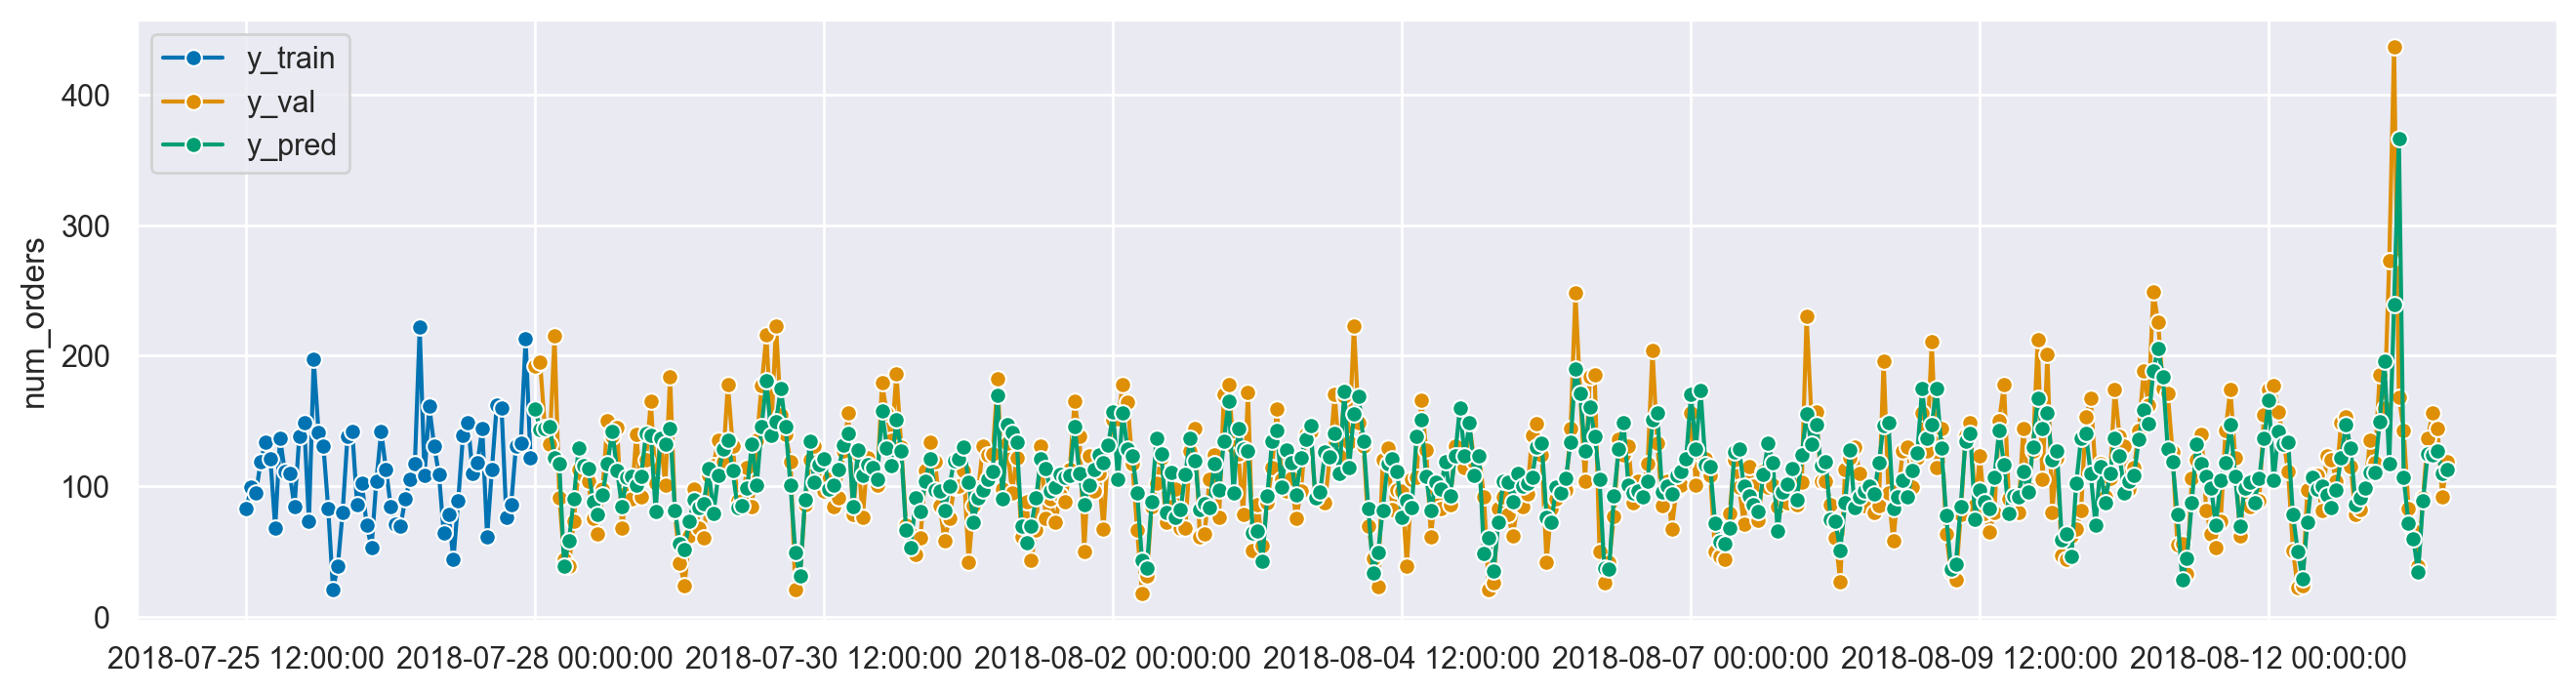

In [41]:
temp_data = df.copy()
make_features(temp_data, 225, 75, 20, 20, 70)
train, val = train_test_split(temp_data, shuffle=False, test_size=0.1)
train = train.dropna()
y_train = train['diff']
y_train_plot = train['num_orders']
lost_value = train['num_orders'].values[-1]
train = train.drop(columns=['num_orders', 'diff'])
y_val = val['num_orders']
val = val.drop(columns=['num_orders', 'diff'])

booster = lgb.LGBMRegressor(boosting_type='gbdt', 
                            num_leaves=500, 
                            max_depth=100, 
                            learning_rate=0.1, 
                            n_estimators=750, 
                            min_child_samples=50,
                            random_state=42)
booster.fit(train, y_train)
pred = booster.predict(val)
pred = y_val.shift().fillna(lost_value) + pred
y_pred = pd.Series(pred, index=y_val.index)
plot_series(y_train_plot.tail(60), y_val, y_pred, labels=["y_train", "y_val", "y_pred"])
print(f'RMSE: {rmse(y_val, y_pred):.2f}')

## sktime models

Дальше обучим несколько моделей из библиотеки sktime

In [9]:
# Приводим dataframe к нужному формату
y = df.squeeze('columns')
y_train, y_test = temporal_train_test_split(y, test_size=df.shape[0] // 10)
# Создаем временную сетку для заполнения предсказанными значениями
fh = ForecastingHorizon(y_test.index, is_relative=False)

Для начала, посмотрим на наивной сезонной модели какой период сезонности показывает лучшее качество - попробуем суточную и недельную периоды.

RMSE: 42.53


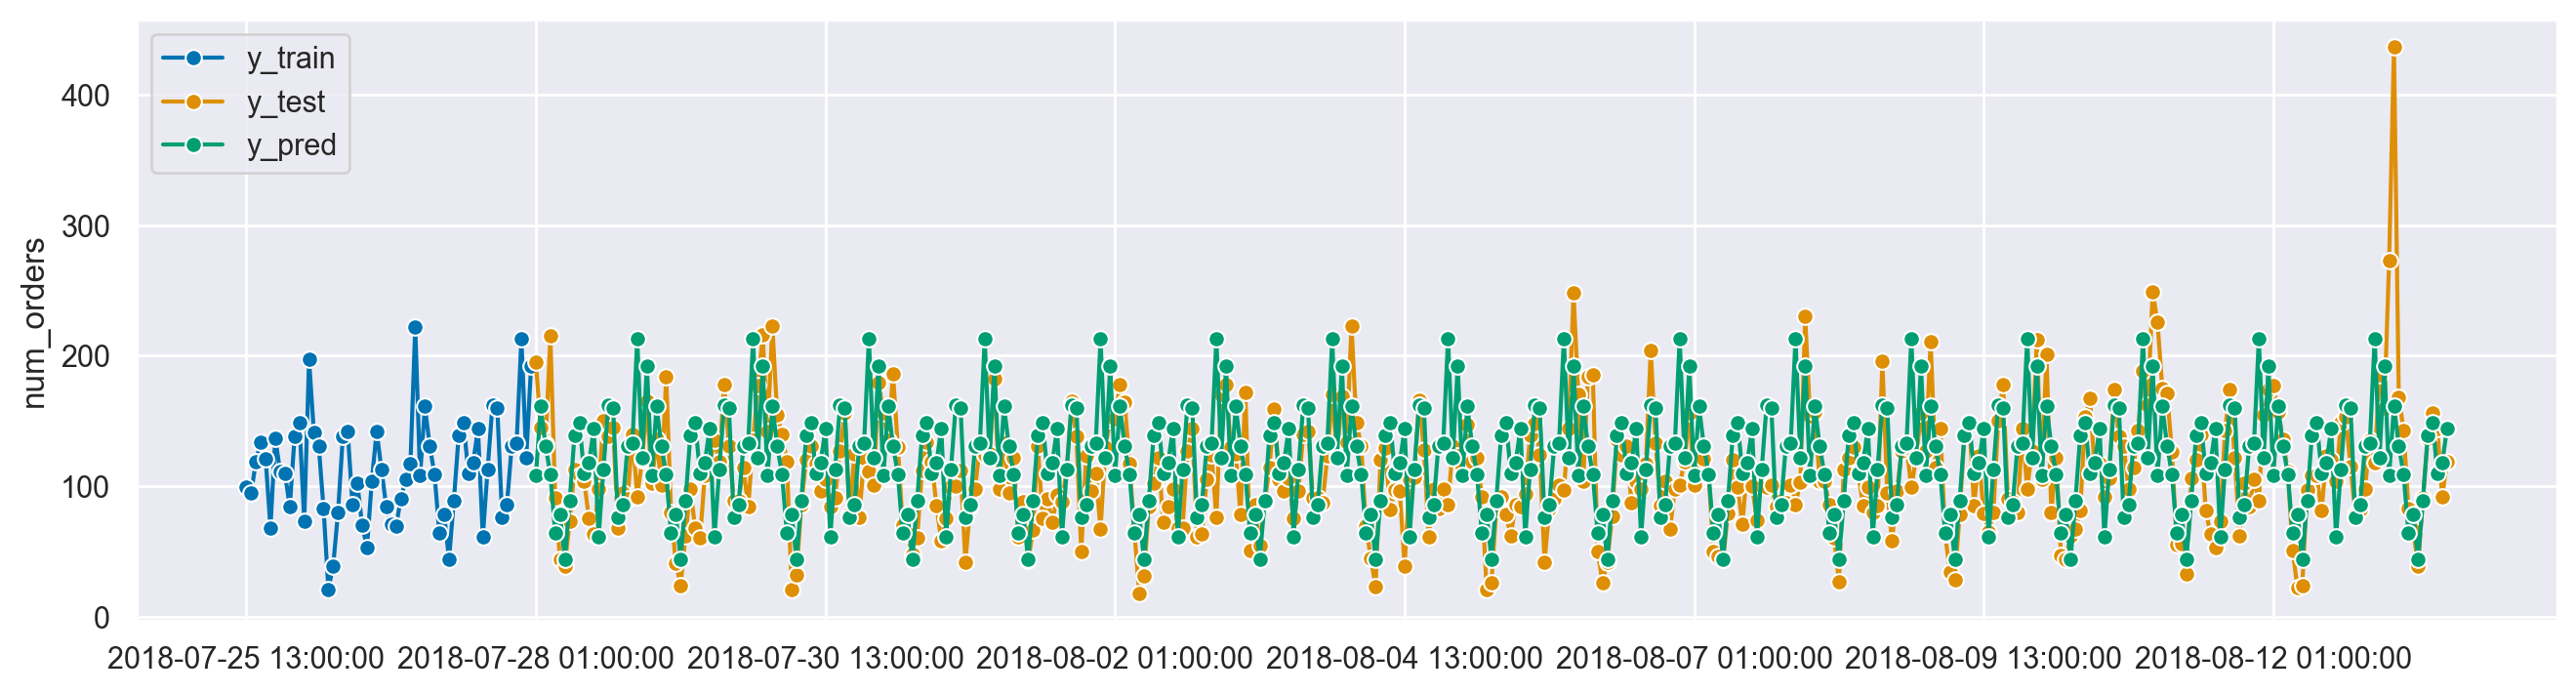

In [10]:
forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

RMSE: 32.64


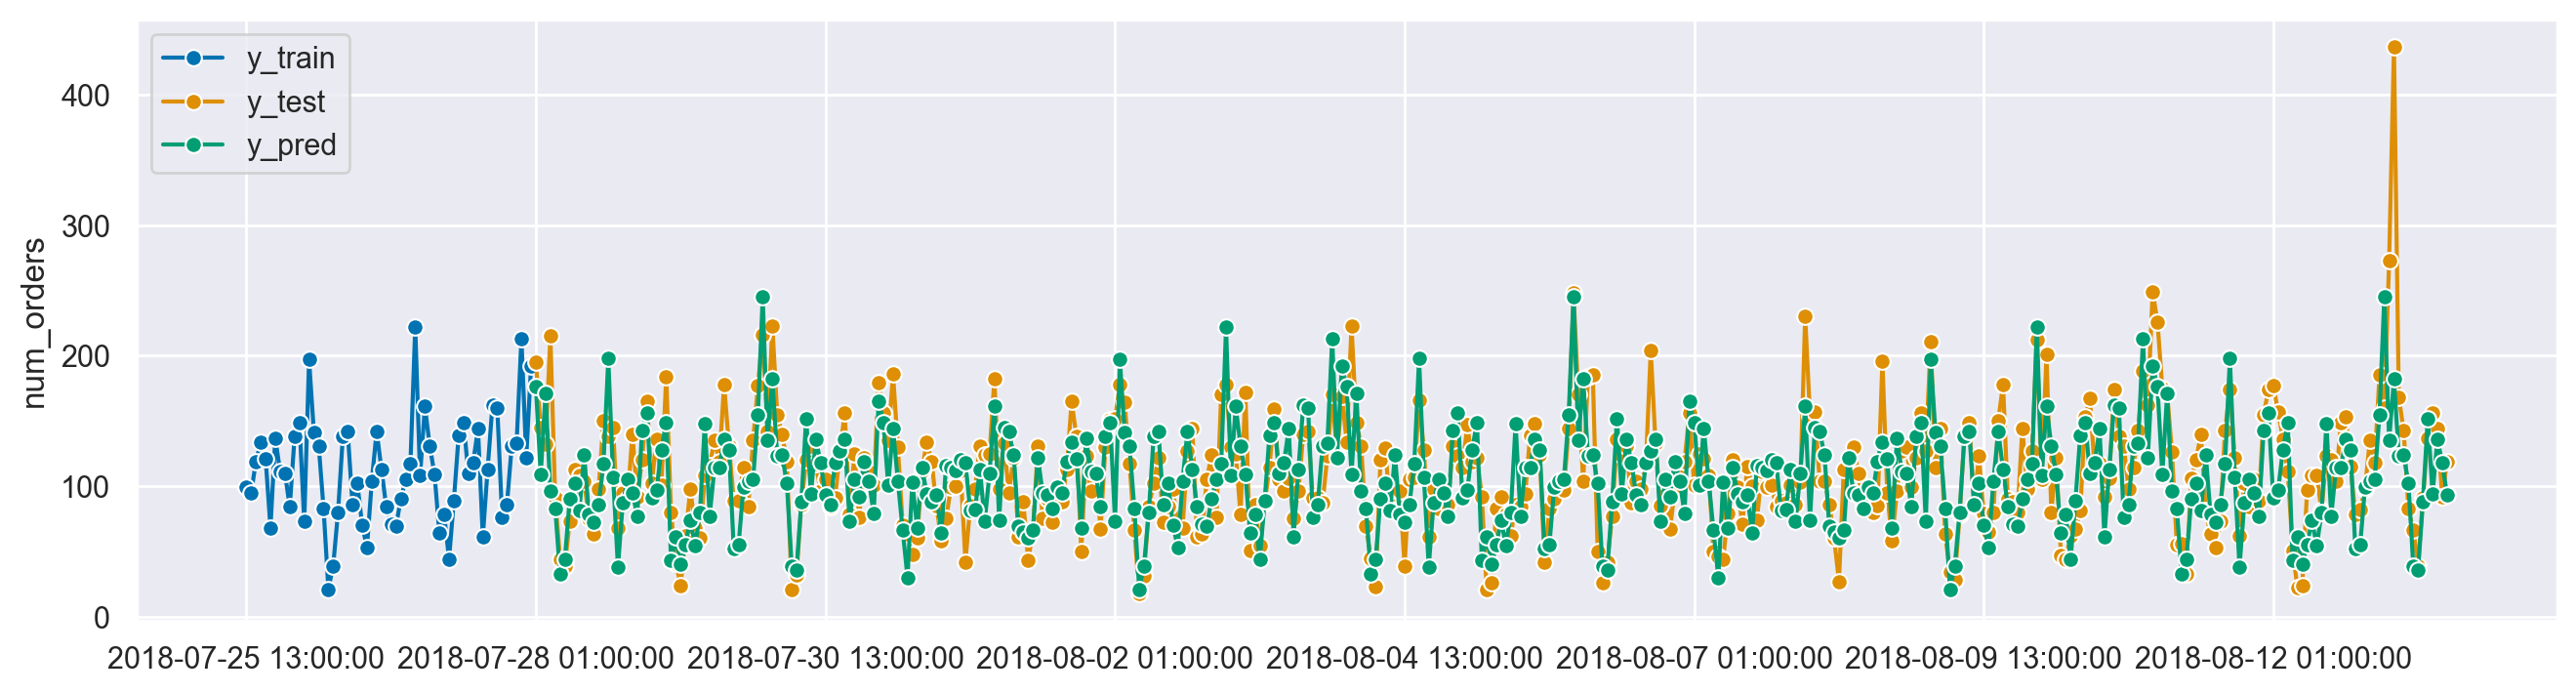

In [11]:
forecaster = NaiveForecaster(strategy="last", sp=168)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
rmse(y_test, y_pred)
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

### TBATS sktime

RMSE: 31.88
CPU times: total: 12 s
Wall time: 7min 30s


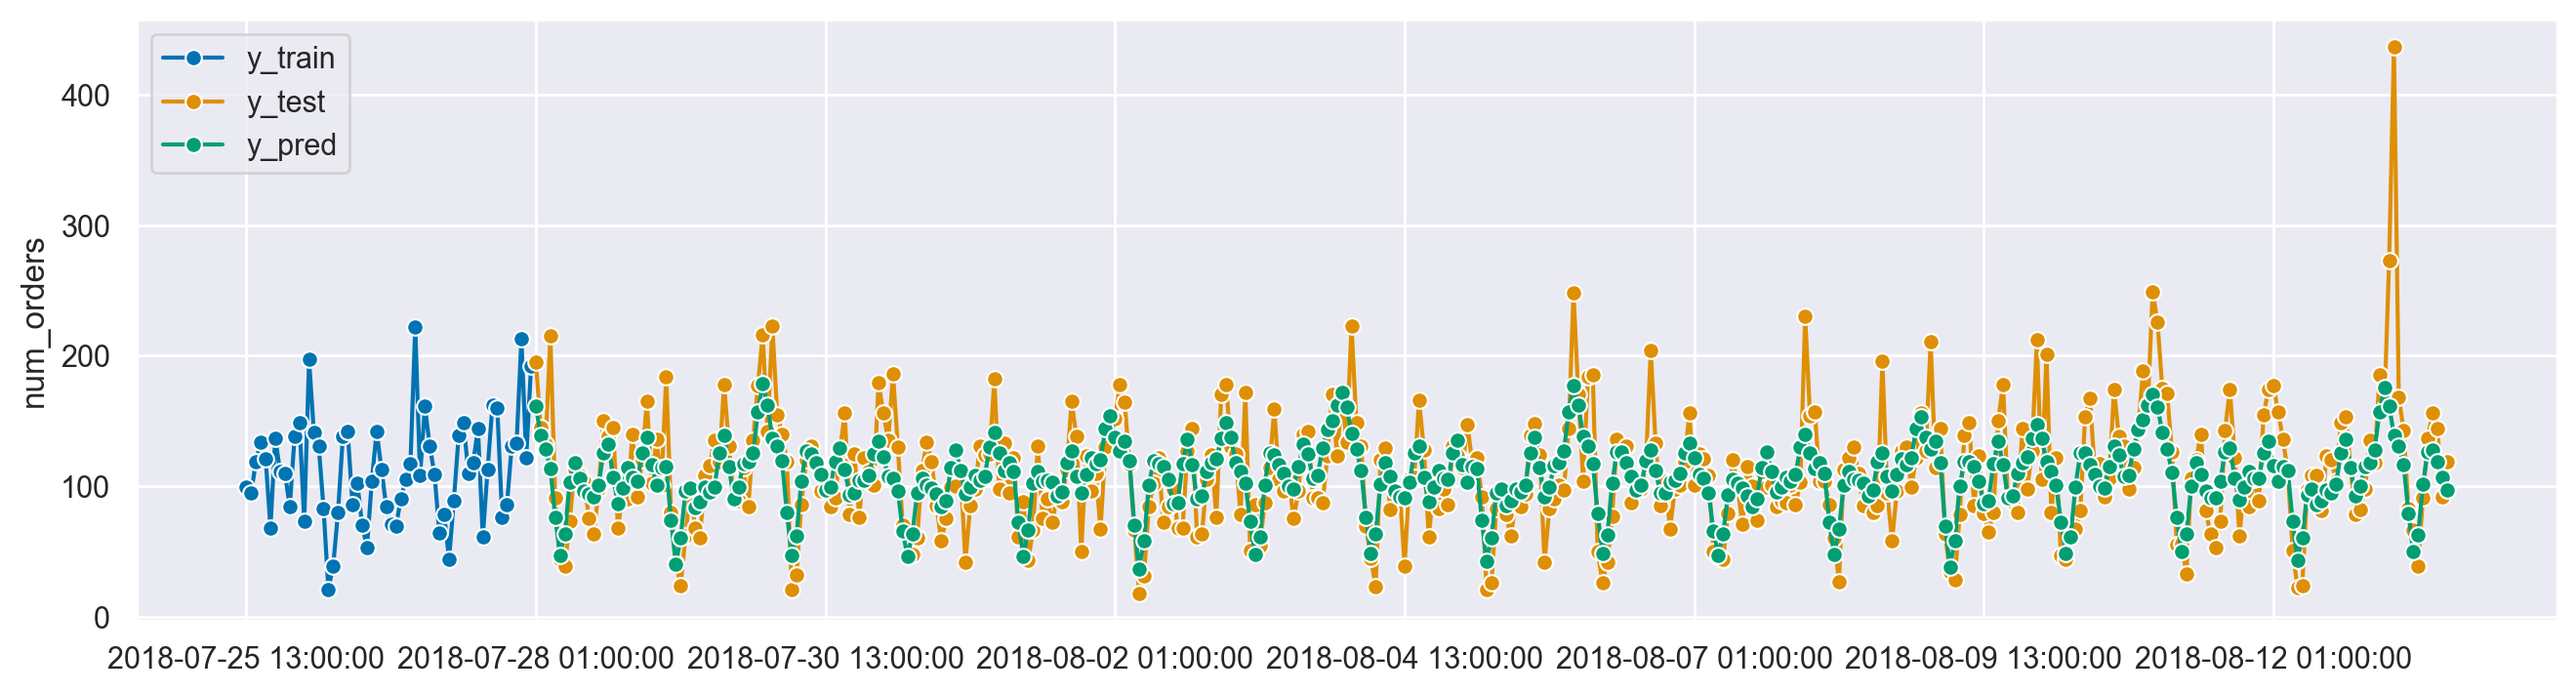

In [45]:
%%time
forecaster = TBATS(sp=168, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

### KNeighborsRegressor sktime

In [46]:
params_list = list(itertools.product([2, 5, 7, 10, 20, 30, 50, 100],
                                     [2, 5, 7, 10, 20, 30, 50, 100]))
best = np.inf
for n_neighbors, window_length in tqdm(params_list):
    regressor = KNeighborsRegressor(n_neighbors=n_neighbors)
    forecaster = make_reduction(regressor, window_length=window_length, strategy="recursive")
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    score = rmse(y_test, y_pred)
    if score < best:
        best = score
        best_params = n_neighbors, window_length
print(f'''score: {best:.2f}
n_neighbors: {best_params[0]}
window_length: {best_params[1]} ''')

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:21<00:00,  3.14s/it]

score: 31.44
n_neighbors: 2
window_length: 30 


RMSE: 31.44
CPU times: total: 31.4 s
Wall time: 6.15 s


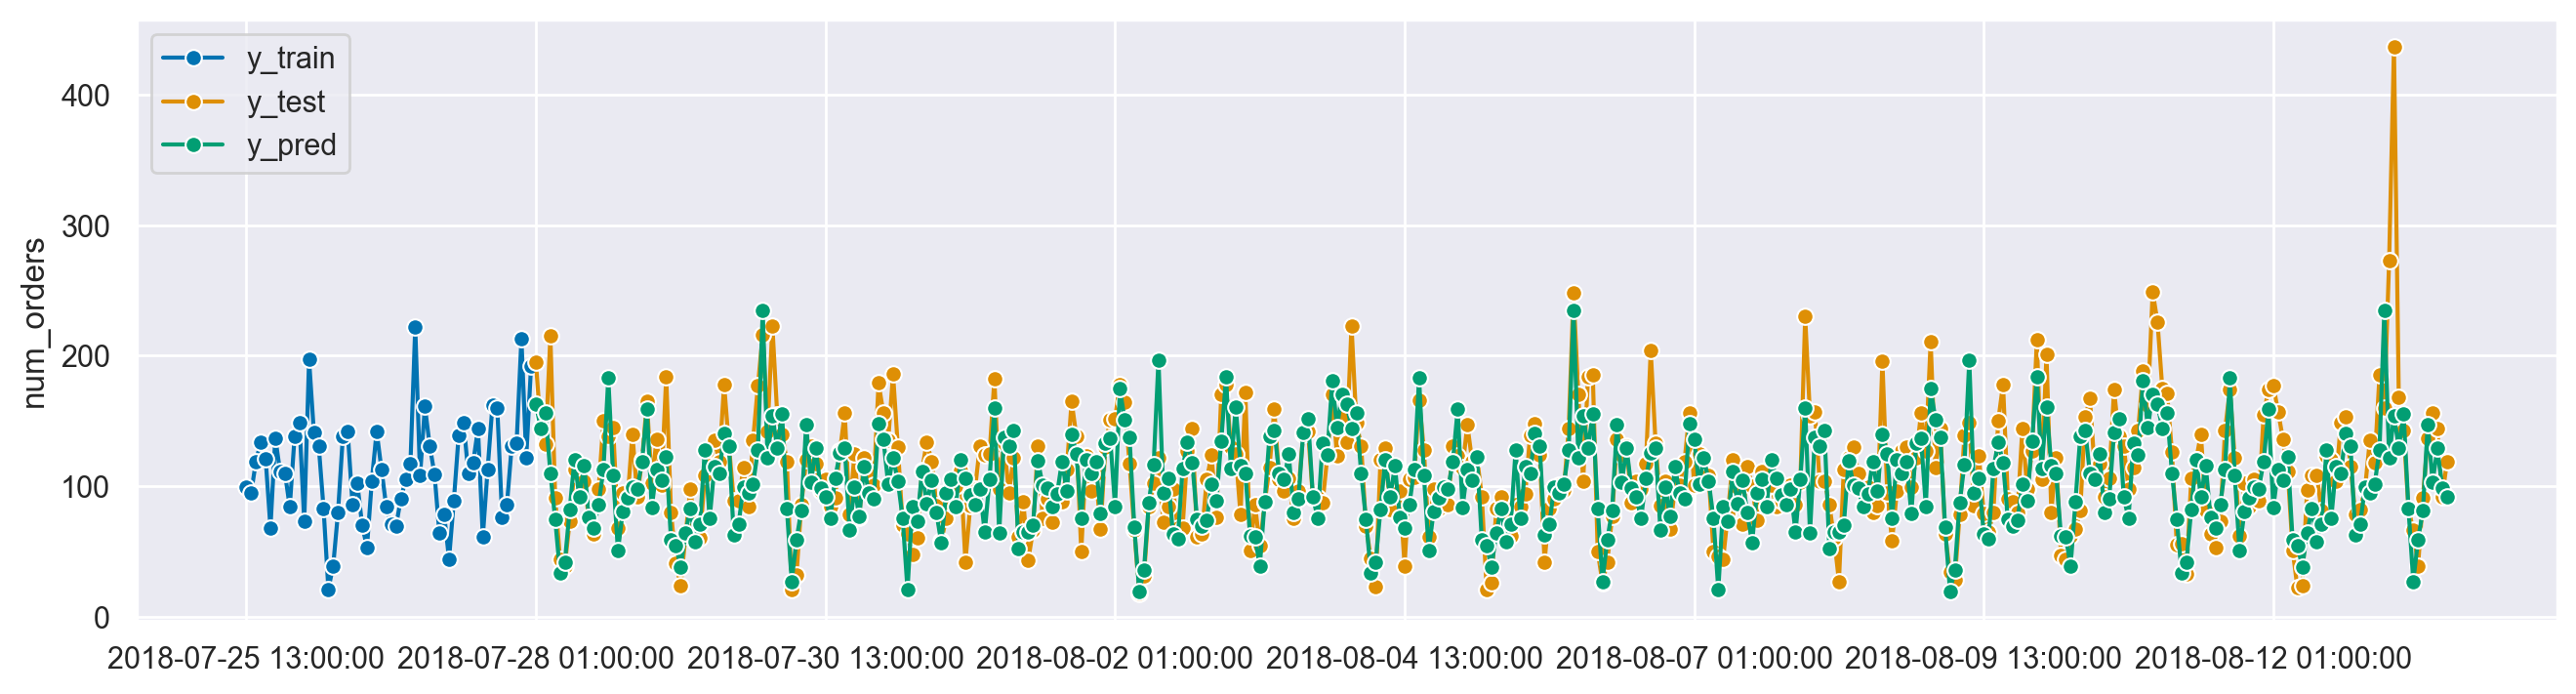

In [47]:
%%time
regressor = KNeighborsRegressor(n_neighbors=2)
forecaster = make_reduction(regressor, window_length=30, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

### LinearRegression sktime

RMSE: 28.34
CPU times: total: 328 ms
Wall time: 331 ms


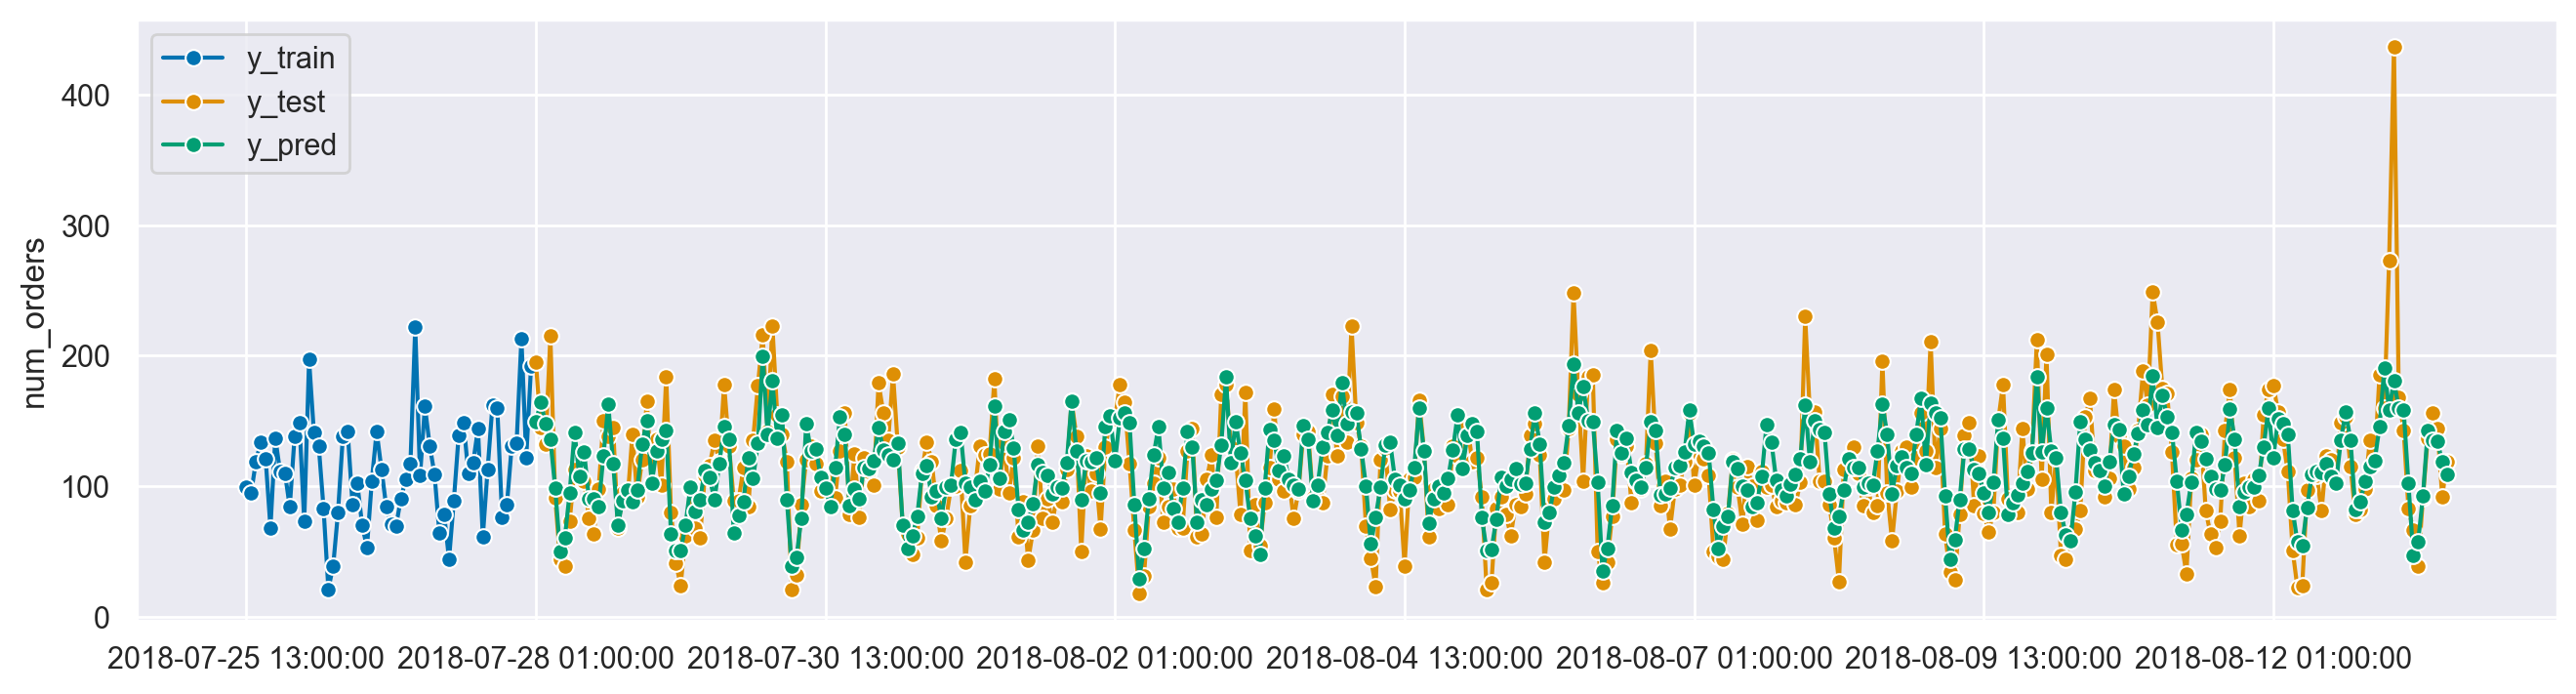

In [48]:
%%time
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=345, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

### CatBoostRegressor sktime

In [525]:
ls = []
params_list = list(itertools.product([None, 500, 1000, 2000],
                                     [None, 0.001, 0.01, 0.1],
                                     [None, 4, 7, 10],
                                     [None, 0.001, 0.01, 0.1, 1, 10],
                                     [24, 168, 336],))
best = np.inf
for iterations, learning_rate, depth, l2_leaf_reg, window_length in tqdm(params_list):
    regressor = CatBoostRegressor(iterations=iterations,
                                  learning_rate=learning_rate,
                                  depth=depth,
                                  l2_leaf_reg=l2_leaf_reg,
                                  silent=True)
    forecaster = make_reduction(regressor, window_length=window_length, scitype="tabular-regressor")
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    score = rmse(y_test, y_pred)
    if score < best:
        best = score
        best_params = iterations, learning_rate, depth, l2_leaf_reg, window_length
    ls.append([score, iterations, learning_rate, depth, l2_leaf_reg, window_length])
print(f'''score: {best:.2f}
iterations: {best_params[0]}
learning_rate: {best_params[1]}
depth: {best_params[2]}
l2_leaf_reg: {best_params[3]}
window_length: {best_params[4]}''')

 86%|███████████████████████████████████████████████████████████████▌          | 989/1152 [13:42:47<2:15:36, 49.92s/it]


KeyboardInterrupt: 

In [527]:
df_grid = pd.DataFrame(ls, columns=['score', 'iterations', 'learning_rate', 'depth', 'l2_leaf_reg', 'window_length'])
df_grid.sort_values(by='score').head(10)

score  iterations  learning_rate  depth  l2_leaf_reg  window_length
260  29.984626         NaN            0.1    7.0         0.01            336
836  29.984626      1000.0            0.1    7.0         0.01            336
254  29.998509         NaN            0.1    7.0          NaN            336
830  29.998509      1000.0            0.1    7.0          NaN            336
542  30.059515       500.0            0.1    7.0          NaN            336
548  30.128948       500.0            0.1    7.0         0.01            336
842  30.388886      1000.0            0.1    7.0         1.00            336
266  30.388886         NaN            0.1    7.0         1.00            336
344  30.412983       500.0            NaN   10.0          NaN            336
839  30.428138      1000.0            0.1    7.0         0.10            336

### AutoETS sktime

RMSE: 28.23
CPU times: total: 172 ms
Wall time: 1min 37s


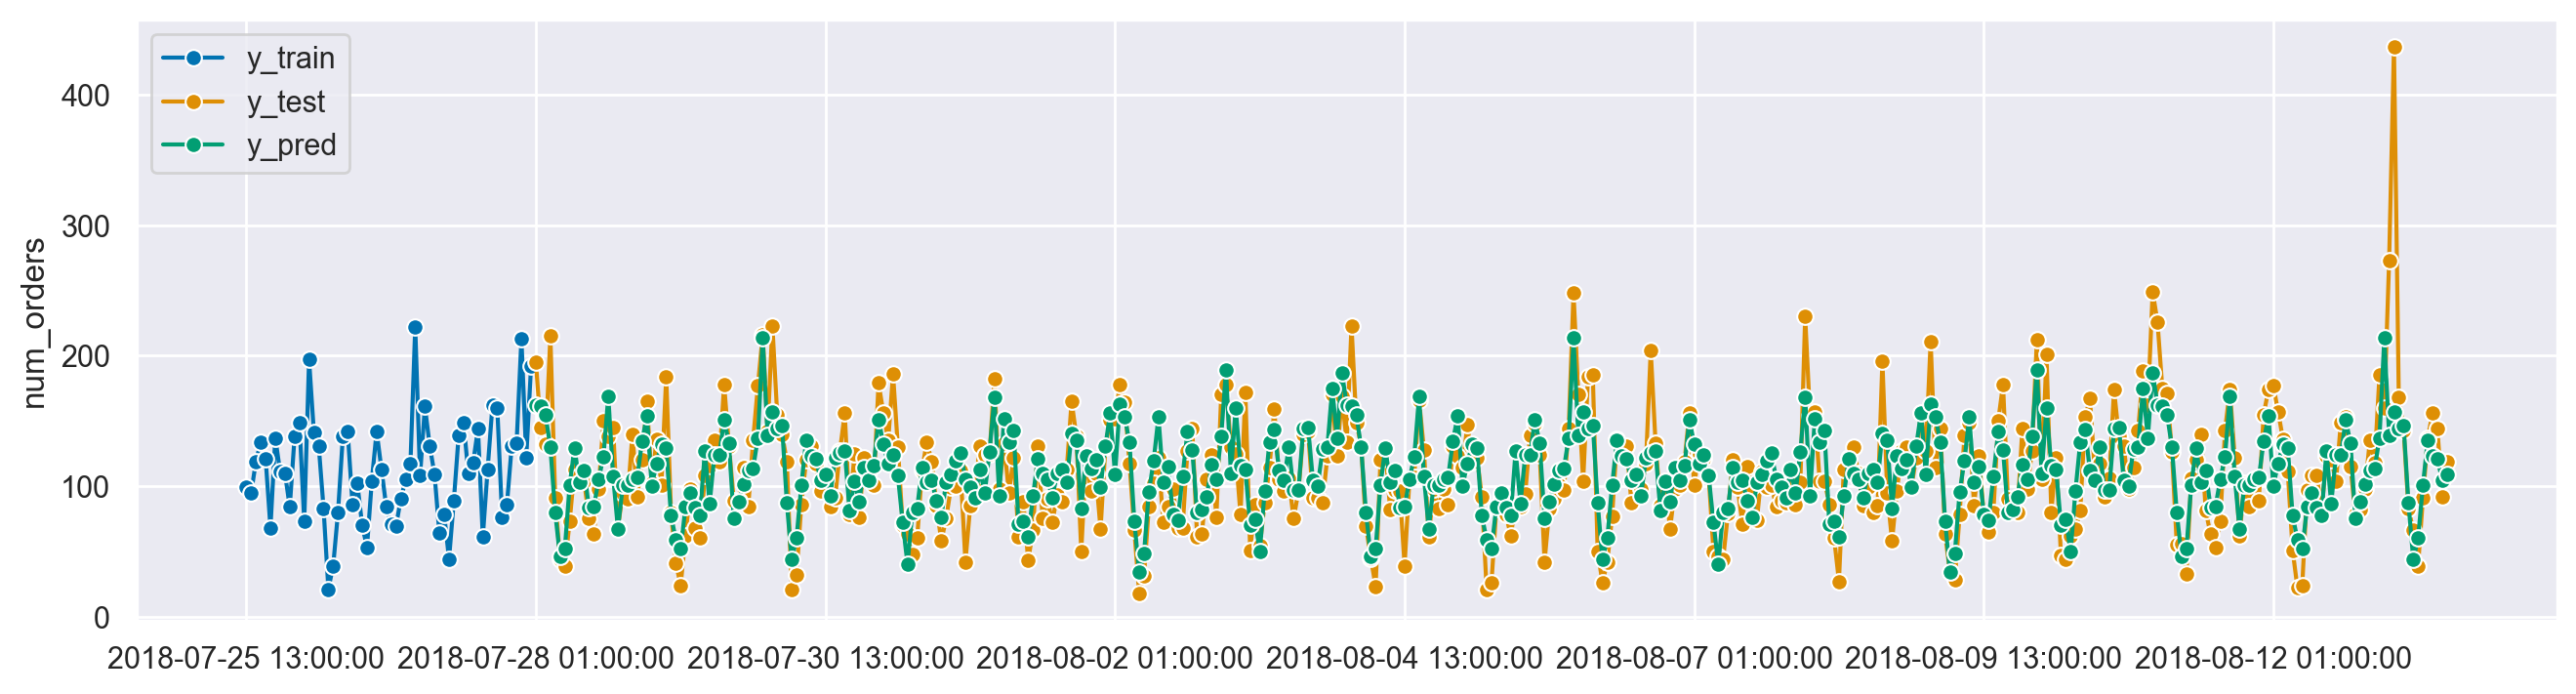

In [12]:
%%time
forecaster = AutoETS(auto=True, sp=168, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

## Final test

### Baseline final

In [14]:
const_mean = np.ones(test.shape[0]) * df.mean().values[0]
const_last = np.ones(test.shape[0]) * df.values[-1]
dynamic_last = test.shift().fillna(df.values[-1][0])
print(f'''constant mean score: {rmse(test, const_mean)}
constant last score: {rmse(test, const_last)}
dynamic last score: {rmse(test, dynamic_last)}''')

constant mean score: 84.74414402014742
constant last score: 62.05343632125475
dynamic last score: 58.856486242815066


### LinearRegression final

RMSE: 35.77
CPU times: total: 2.53 s
Wall time: 2.36 s


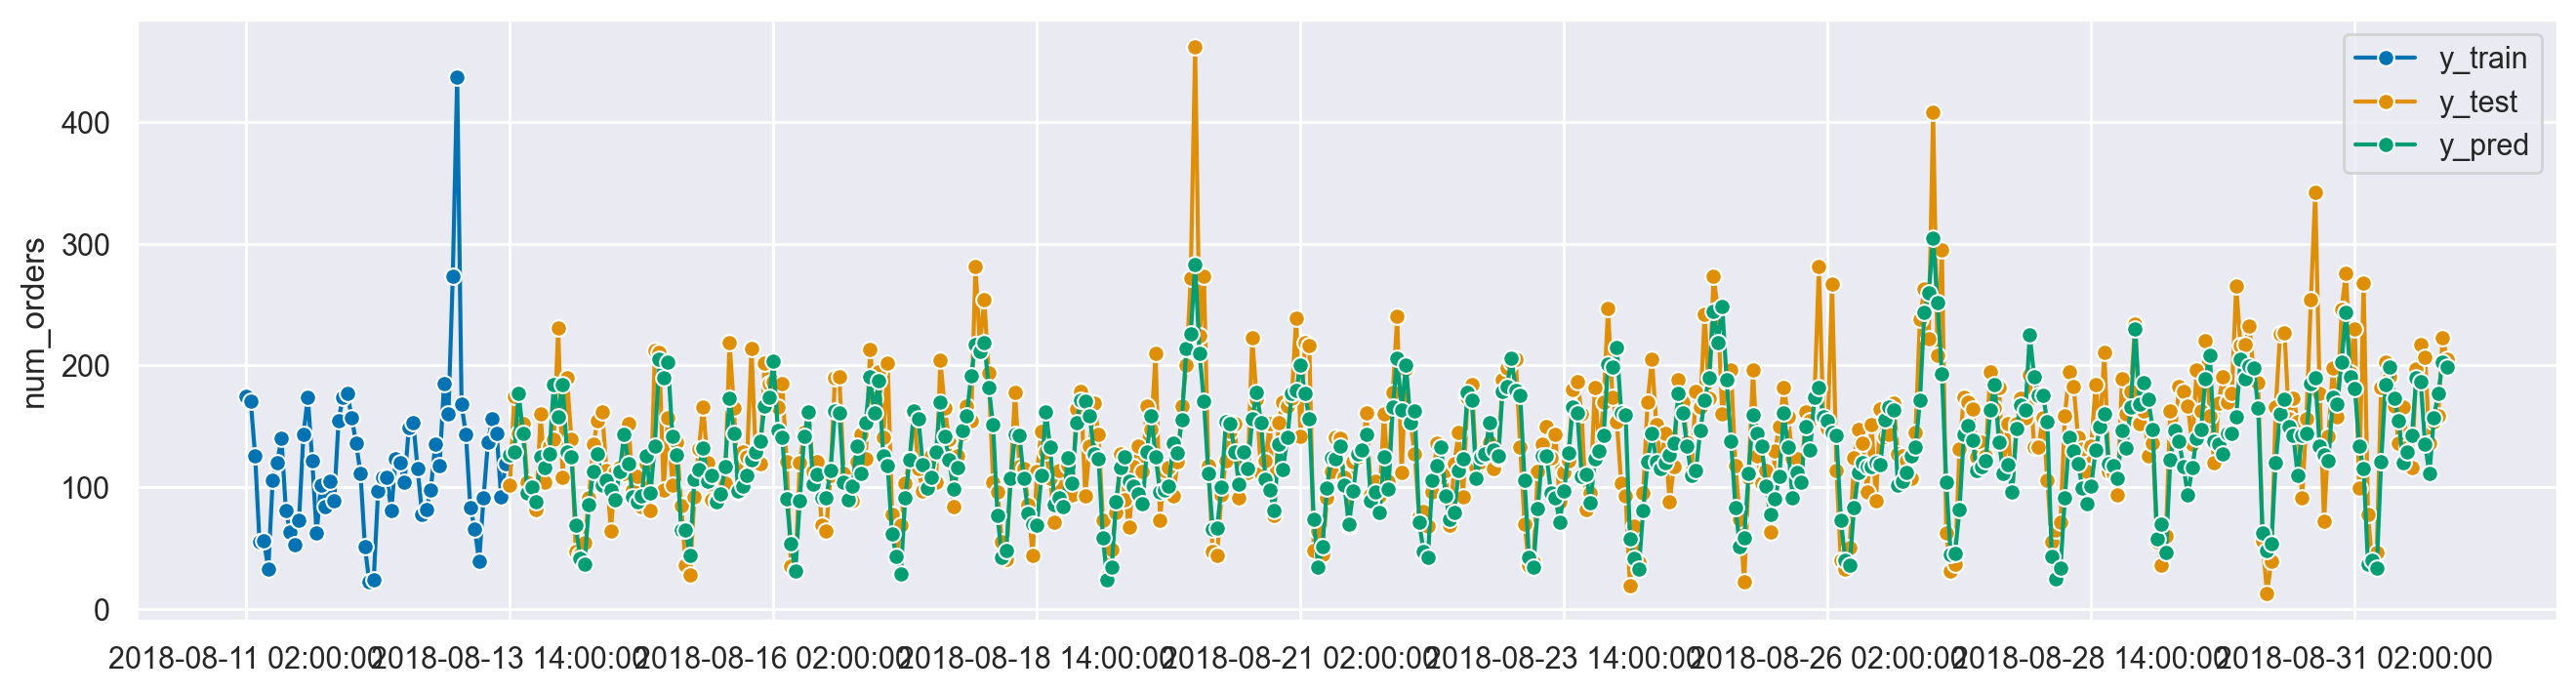

In [19]:
%%time
temp_data = df_full.copy()
make_features(temp_data, 200, 5, 2, 60, 7, 100)
train, test = train_test_split(temp_data, shuffle=False, test_size=0.1)
train = train.dropna()
y_train = train['num_orders']
train = train.drop(columns='num_orders')
y_test = test['num_orders']
test = test.drop(columns='num_orders')
model = LinearRegression()
model.fit(train, y_train)
pred = model.predict(test)
y_pred = pd.Series(pred, index=y_test.index)
plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'RMSE: {rmse(y_test, y_pred):.2f}')

Наилучшая модель -  линейная регрессия на сгенерированных признаках временного ряда (месяц, число, день недели, час, некоторое количество прошлых значений, среднее прошлых значений посчитанных скользящим и расширяющимся окном, количество пиков и эксцесс Фишера и разница между прошлыми значениями). RMSE на отложенной тестовой выборке: 35.77